In [239]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import chi2,kstest,norm, genextreme
from scipy.optimize import minimize_scalar,minimize
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import arch
import matplotlib.pyplot as plt
import math

In [240]:


# Save path 
 # save_dir = r"C:\Users\remyd\OneDrive\Bureau\HEC\Master finance\Second semester\Empirical methods in finance\Projet II\table"



# Opening of the file
data = pd.read_excel(r"C:\Users\remyd\OneDrive\Bureau\HEC\Master finance\Second semester\Empirical methods in finance\Projet II\data emf project 2.xlsx",sheet_name="Weekly data")
data_2 = pd.read_excel(r"C:\Users\remyd\OneDrive\Bureau\HEC\Master finance\Second semester\Empirical methods in finance\Projet II\data emf project 2.xlsx",sheet_name="Daily data")
# Rename column
data = data.rename(columns={'S&P 500 COMPOSITE - TOT RETURN IND': 'SP500','MSCI PACIFIC U$ - TOT RETURN IND':'MSCI P','US DOLLAR S/T DEPOSIT (FT/RFV) - MIDDLE RATE':'US RATE annualized'})
# Set date as index
data['Date'] = pd.to_datetime(data['Date'])         
data.set_index('Date', inplace=True)
# Divide risk-free rate by 100 since it's in %
data['US RATE annualized']=data['US RATE annualized']/100

In [241]:
data

,SP500,MSCI P,US RATE annualized
Date,,,
2001-01-01,1837.36,3250.437,0.066875
2001-01-08,1804.04,3248.597,0.058906
2001-01-15,1835.53,3094.317,0.060000
2001-01-22,1869.89,3252.142,0.059688
2001-01-29,1899.75,3218.110,0.060625
...,...,...,...
2023-11-27,9836.75,8790.228,0.053650
2023-12-04,9884.17,8817.889,0.053650
2023-12-11,10000.64,8830.855,0.053650


In [242]:
#Setting DataFrame
Weekly_simple_return = pd.DataFrame()
# Simple returns for stocks and bonds
for column in data.columns[:-1]:
    new_column_name = f'Weekly_simple_return_{column}'
    Weekly_simple_return[new_column_name] = data[column].pct_change()
#Simple return for risk-free rate
Weekly_simple_return['US RATE'] = data['US RATE annualized']/52 # Since it's annualized
# Drop first row
Weekly_simple_return = Weekly_simple_return.drop(Weekly_simple_return.index[0])

In [243]:
Weekly_simple_return

,Weekly_simple_return_SP500,Weekly_simple_return_MSCI P,US RATE
Date,,,
2001-01-08,-0.018135,-0.000566,0.001133
2001-01-15,0.017455,-0.047491,0.001154
2001-01-22,0.018719,0.051005,0.001148
2001-01-29,0.015969,-0.010464,0.001166
2001-02-05,-0.006985,-0.010518,0.001058
...,...,...,...
2023-11-27,0.000786,-0.003130,0.001032
2023-12-04,0.004821,0.003147,0.001032
2023-12-11,0.011783,0.001470,0.001032


# 1 Static allocation

Q1.2

In [244]:
# Compute the mean for stock, bond and Rf
μ_s= Weekly_simple_return['Weekly_simple_return_SP500'].mean()
μ_b= Weekly_simple_return['Weekly_simple_return_MSCI P'].mean()
Rf= Weekly_simple_return['US RATE'].mean()

# Compute the covariance matrix and its inverse
cov_matrix_static = np.cov(Weekly_simple_return['Weekly_simple_return_SP500'],Weekly_simple_return['Weekly_simple_return_MSCI P'], rowvar=False)
inv_cov_matrix_static = np.linalg.inv(cov_matrix_static)
#Set the parameters + matrices
λ_2 = 2
λ_10 = 10
mu = np.array([[μ_s], [μ_b]])
e = np.ones([len(mu), 1])

In [245]:
# Optimal weights for λ = 2
alpha_opti_1_static = (1/λ_2)*inv_cov_matrix_static@(mu-e*Rf)
alpha_Rf_1_static = 1 - e.T@alpha_opti_1_static
# Optimal weights for λ = 10
alpha_opti_2_static = (1/λ_10)*inv_cov_matrix_static@(mu-e*Rf)
alpha_Rf_2_static = 1 - e.T@alpha_opti_2_static

In [246]:
# Print the results
opti_w_res = {
    'λ = 2': np.concatenate((alpha_opti_1_static.flatten(), alpha_Rf_1_static [0])),
    'λ = 10': np.concatenate((alpha_opti_2_static.flatten(), alpha_Rf_2_static[0]))
}

df = pd.DataFrame(opti_w_res, index=['Weight SP500', 'Weight MSCI P', 'Weight Rf'])
df

,λ = 2,λ = 10
Weight SP500,1.119974,0.223995
Weight MSCI P,-0.048201,-0.009640
Weight Rf,-0.071773,0.785645


# 2 Estimation of a GARCH model

In [247]:
# Compute excess returns
ex_R_SP500 = Weekly_simple_return['Weekly_simple_return_SP500'] - Weekly_simple_return['US RATE']
ex_R_MSCI = Weekly_simple_return['Weekly_simple_return_MSCI P'] - Weekly_simple_return['US RATE']
# Compute squared excess return
ex_R_SP500_sq = ex_R_SP500**2
ex_R_MSCI_sq = ex_R_MSCI**2

# Create a DataFrame
excess_r_res = {
    'Excess return S&P500': ex_R_SP500,
    'Excess return S&P500 squared': ex_R_SP500_sq,
    'Excess return MSCI': ex_R_MSCI,
    'Excess return MSCI squared': ex_R_MSCI_sq
}

# Standardize the variables
ex_R_SP500_standardized = (ex_R_SP500 - ex_R_SP500.mean()) / ex_R_SP500.std()
ex_R_MSCI_standardized = (ex_R_MSCI - ex_R_MSCI.mean()) / ex_R_MSCI.std()
ex_R_SP500_sq_standardized = ex_R_SP500_standardized**2
ex_R_MSCI_sq_standardized = ex_R_MSCI_standardized**2

# Create a DataFrame for excess returns
excess_r_res_standardized = {
    'Excess return S&P500 standardized': ex_R_SP500_standardized,
    'Excess return S&P500 squared standardized': ex_R_SP500_sq_standardized,
    'Excess return MSCI standardized': ex_R_MSCI_standardized,
    'Excess return MSCI squared standardized': ex_R_MSCI_sq_standardized
}
pd.DataFrame(excess_r_res)

,Excess return S&P500,Excess return S&P500 squared,Excess return MSCI,Excess return MSCI squared
Date,,,,
2001-01-08,-0.019268,3.712374e-04,-0.001699,2.886212e-06
2001-01-15,0.016301,2.657363e-04,-0.048645,2.366347e-03
2001-01-22,0.017572,3.087591e-04,0.049857,2.485715e-03
2001-01-29,0.014803,2.191285e-04,-0.011630,1.352651e-04
2001-02-05,-0.008043,6.468698e-05,-0.011575,1.339889e-04
...,...,...,...,...
2023-11-27,-0.000245,6.016429e-08,-0.004162,1.732207e-05
2023-12-04,0.003789,1.435627e-05,0.002115,4.473475e-06
2023-12-11,0.010752,1.156003e-04,0.000439,1.924482e-07


In [248]:
pd.DataFrame(excess_r_res_standardized)

,Excess return S&P500 standardized,Excess return S&P500 squared standardized,Excess return MSCI standardized,Excess return MSCI squared standardized
Date,,,,
2001-01-08,-0.802255,0.643613,-0.098937,0.009789
2001-01-15,0.575042,0.330674,-1.895893,3.594409
2001-01-22,0.624224,0.389655,1.874460,3.513600
2001-01-29,0.517020,0.267310,-0.479083,0.229520
2001-02-05,-0.367613,0.135139,-0.476978,0.227508
...,...,...,...,...
2023-11-27,-0.065678,0.004314,-0.193217,0.037333
2023-12-04,0.090536,0.008197,0.047049,0.002214
2023-12-11,0.360149,0.129707,-0.017117,0.000293


Q2.1

Kolmogorov-Smirnov test for non-normality

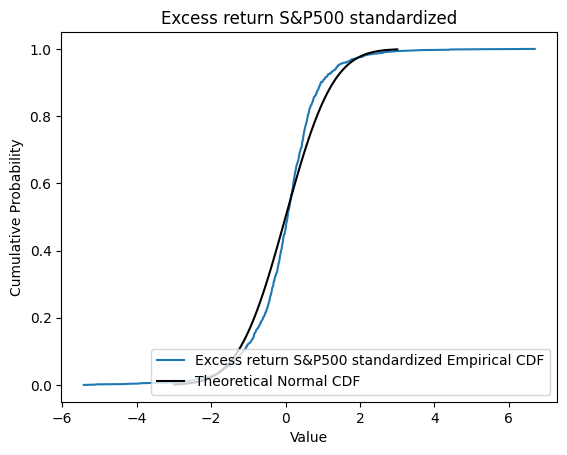

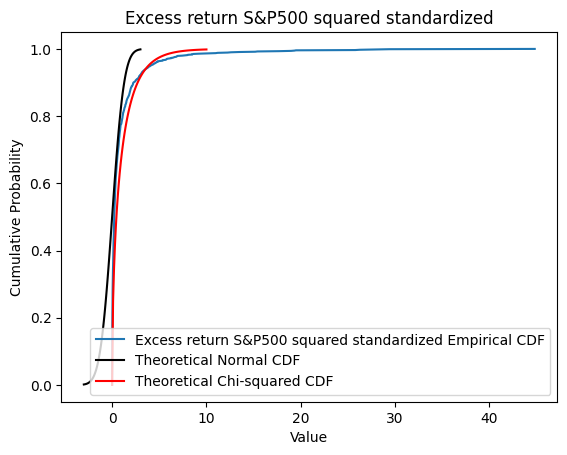

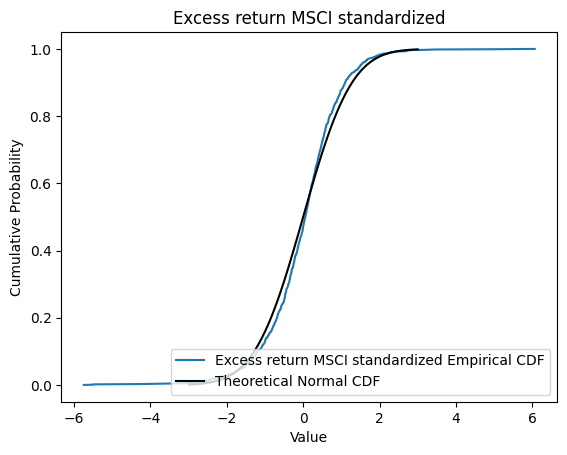

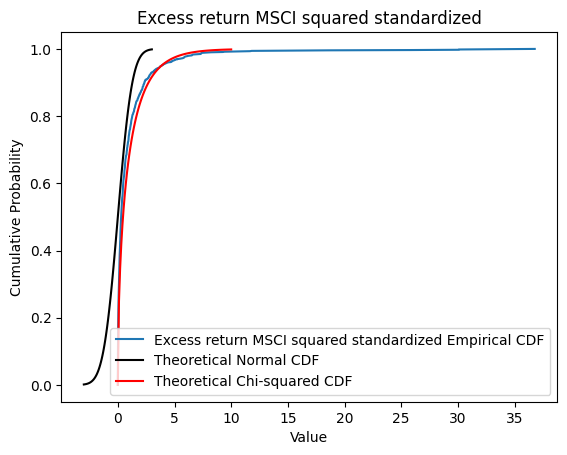

,Variable,KS Statistic (Normal),P-value (Normal),KS Statistic (Chi-squared),P-value (Chi-squared)
0,Excess return S&P500 standardized,0.083604,9.717054e-08,NaN,nan
1,Excess return S&P500 squared standardized,0.500001,1.053799e-277,0.152241,0.0000000000
2,Excess return MSCI standardized,0.059167,4.324920e-04,NaN,nan
3,Excess return MSCI squared standardized,0.500000,1.055446e-277,0.095111,0.0000000007


In [249]:
# Create a list to store the KS test results
ks_results = [] 

# Loop through each variable
for var_name, var_data in excess_r_res_standardized.items():
    # Create a new figure and axes for each variable
    fig, ax = plt.subplots()

    # Perform the Kolmogorov-Smirnov test for normal distribution
    ks_statistic_normal, p_value_normal = stats.kstest(var_data, 'norm')
    
    # Perform the Kolmogorov-Smirnov test for chi-squared distribution
    if 'squared' in var_name.lower():
        ks_statistic_chi2, p_value_chi2 = stats.kstest(var_data, 'chi2', args=(1,))
    else:
        # If it's not a squared variable, set the chi-squared test results to None
        ks_statistic_chi2, p_value_chi2 = None, None
    
    ks_results.append({'Variable': var_name, 
                       'KS Statistic (Normal)': ks_statistic_normal, 
                       'P-value (Normal)': p_value_normal,
                       'KS Statistic (Chi-squared)': ks_statistic_chi2,
                       'P-value (Chi-squared)': p_value_chi2})
    
    # Sort the data for plotting
    sorted_data = np.sort(var_data)
    
    # Calculate the empirical CDF
    cdf = np.linspace(0, 1, len(var_data))
    
    # Plot the empirical CDF
    ax.plot(sorted_data, cdf, label=f'{var_name} Empirical CDF')

    # Plot the theoretical CDF of a standard normal distribution
    x_normal = np.linspace(-3, 3, 100)
    y_normal = stats.norm.cdf(x_normal)
    ax.plot(x_normal, y_normal, label='Theoretical Normal CDF', color='black')
    
    # Plot the theoretical CDF of a chi-squared distribution with 1 degree of freedom
    if 'squared' in var_name.lower():
        x_chi2 = np.linspace(0, 10, 100)
        y_chi2 = stats.chi2.cdf(x_chi2, df=1)
        ax.plot(x_chi2, y_chi2, label='Theoretical Chi-squared CDF', color='red')

    # Add legend and labels
    ax.legend()
    ax.set_xlabel('Value')
    ax.set_ylabel('Cumulative Probability')

    # Set title
    ax.set_title(var_name)

    # Show the plot
    plt.show()

# Print the KS test results
ks_results_df = pd.DataFrame(ks_results)
ks_results_df['P-value (Chi-squared)'] = ks_results_df['P-value (Chi-squared)'].apply(lambda x: "{:.10f}".format(x) if x is not None else None)
ks_results_df

Ljung-Box test with 4 lags

In [250]:
# Create list
lb_results = []

# Perform Ljung-Box test for each column in excess_r_res
for column in excess_r_res:
    lb_results.append(sm.stats.acorr_ljungbox(excess_r_res[column], lags=4))

# Print the results 
lb_results_df = pd.concat([lb_results[0], lb_results[1],lb_results[2],lb_results[3]], axis=1)
second_title = pd.MultiIndex.from_tuples([('Excess return S&P500', 'lb_stat'), ('Excess return S&P500', 'lb_pvalue'),
                                          ('Excess return S&P500 squared', 'lb_stat'), ('Excess return S&P500 squared', 'lb_pvalue'),
                                          ('Excess return MSCI', 'lb_stat'),('Excess return MSCI', 'lb_pvalue'),
                                          ('Excess return MSCI squared', 'lb_stat'), ('Excess return MSCI squared', 'lb_pvalue'), 
                                                ])
lb_results_df.columns = second_title
lb_results_df.index.name = 'Lags'
lb_results_df

Excess return S&P500           Excess return S&P500 squared  \
                  lb_stat lb_pvalue                      lb_stat   
Lags                                                               
1                6.987895  0.008206                   146.044317   
2                6.989813  0.030352                   257.377151   
3                7.530970  0.056768                   338.080878   
4                8.101169  0.087942                   361.495015   

                   Excess return MSCI           Excess return MSCI squared  \
         lb_pvalue            lb_stat lb_pvalue                    lb_stat   
Lags                                                                         
1     1.269559e-33           4.439934  0.035108                  99.703984   
2     1.291998e-56           4.545057  0.103051                 296.239550   
3     5.680668e-73           5.502740  0.138475                 366.072961   
4     5.778609e-77           5.503023  0.239464                 389.606973   

                    
         lb_pvalue  
Lags                
1     1.769649e-23  
2     4.703260e-65  
3     4.933691e-79  
4     4.894870e-83

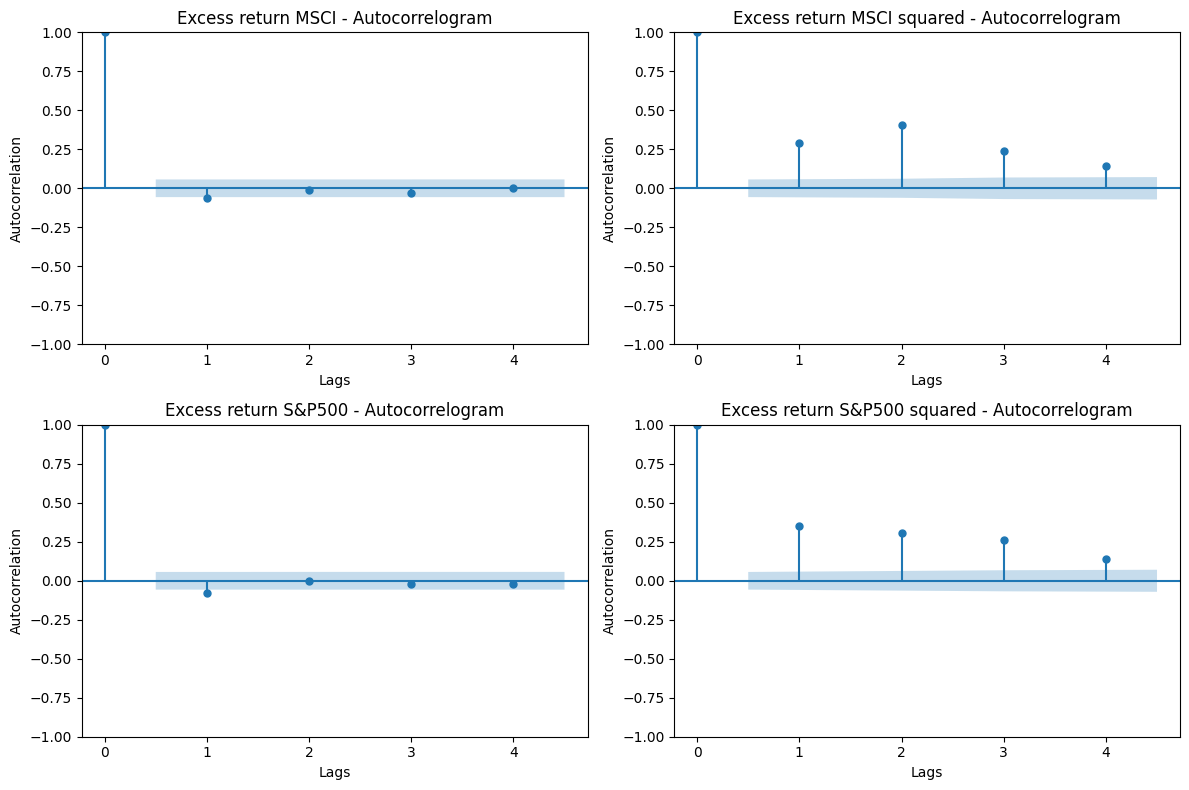

In [251]:

# Plot autocorrelation function for all variables
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Flatten axes for easy iteration
axes = axes.flatten()

# Iterate over all variables
for i, (column, ax) in enumerate(zip(lb_results_df.columns.levels[0], axes)):
    
    # Plot ACF
    plot_acf(excess_r_res[column], lags=4, ax=ax, alpha=0.05)
    
    # Set title and labels
    ax.set_title(f'{column} - Autocorrelogram')
    ax.set_xlabel('Lags')
    ax.set_ylabel('Autocorrelation')

plt.tight_layout()
plt.show()


Q2.2

AR(1) model

In [252]:

# Initialize a list to store AR residuals
AR_res = []
# Initialize dictionaries to store parameters
AR_param = {'Column': [], 'Intercept': [], 'Coefficient': []}

for column in Weekly_simple_return.columns[:-1]:
  

    y = Weekly_simple_return[column].dropna()  # Rt
    X = Weekly_simple_return[column].shift(1).dropna()  # Rt−1
    y = y.drop(y.index[0]) 

    # Add a constant to the independent variable
    X = sm.add_constant(X)

    # Fit the AR(1) model
    model = sm.OLS(y, X).fit()

    # Print the summary
    print(f"AR(1) results for column {column}:")
    print(model.summary())

    '''
    # Define the filename based on the column name
    filename = os.path.join(save_dir, f"AR1_results_{column}.txt")
    
    # Save the summary to a text file
    with open(filename, "w") as text_file:
        text_file.write(f"AR(1) results for column {column}:\n")
        text_file.write(model.summary().as_text())
    '''
    # Calculate residuals
    residuals = pd.DataFrame({f"{column}_residuals": model.resid})

    # Append residuals to the list
    AR_res.append(residuals)

    # Extract parameters (coefficients)
    intercept, coef_rt_1 = model.params
    AR_param['Column'].append(column)
    AR_param['Intercept'].append(intercept)
    AR_param['Coefficient'].append(coef_rt_1)

# Convert parameters dictionary to DataFrame
AR_param_df = pd.DataFrame(AR_param)
  


AR(1) results for column Weekly_simple_return_SP500:
                                OLS Regression Results                                
Dep. Variable:     Weekly_simple_return_SP500   R-squared:                       0.006
Model:                                    OLS   Adj. R-squared:                  0.005
Method:                         Least Squares   F-statistic:                     7.218
Date:                        Thu, 23 May 2024   Prob (F-statistic):            0.00732
Time:                                21:22:27   Log-Likelihood:                 2685.2
No. Observations:                        1198   AIC:                            -5366.
Df Residuals:                            1196   BIC:                            -5356.
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                                 coef    std err          t      P>|t|      [

In [253]:
# Residuals of the AR(1) model
AR_res_df = pd.concat(AR_res,axis=1)
AR_res_df

,Weekly_simple_return_SP500_residuals,Weekly_simple_return_MSCI P_residuals
Date,,
2001-01-15,0.014126,-0.048808
2001-01-22,0.018146,0.046801
2001-01-29,0.015493,-0.008608
2001-02-05,-0.007674,-0.012443
2001-02-12,-0.019869,-0.016217
...,...,...
2023-11-27,0.001305,-0.001921
2023-12-04,0.002956,0.001673
2023-12-11,0.010231,0.000382


Q2.3

GARCH(1,1) model

In [254]:
# List to store GARCH model results
garch_results = []
garch_param = []
cov_matrices = []
garch_res = []
cond_volat = []
for column in AR_res_df.columns:
    # Fit GARCH(1,1) model on AR(1) residuals
    garch_model = arch.arch_model(AR_res_df[column]*100, vol='Garch', p=1, q=1) # Scale to improve accuracy
    garch_result = garch_model.fit()
    # Store GARCH model result
    garch_results.append((column, garch_result))
    
    # Extract GARCH parameters and store in a dictionary
    params_dict = {
        'Column': column,
        'Omega': garch_result.params['omega']/100**2, # Rescale omega by 100^2
        'Alpha': garch_result.params['alpha[1]'],
        'Beta': garch_result.params['beta[1]']
    }
    # Append parameters dictionary to the list
    garch_param.append(params_dict)

    # Compute covariance matrix of the models
    cov_matrices.append(garch_model.compute_param_cov(params=garch_result.params))

    # Extract residuals of the model
    garch_res.append(garch_result.resid/100) # Rescale too
    # compute conditional volatility of the model
    cond_volat.append(garch_result.conditional_volatility/100) 

    '''

    # Define the filename based on the column name
    filename = os.path.join(save_dir, f"GARCH_results_{column}.txt")
    # Save the summary to a text file
    with open(filename, "w") as text_file:
        text_file.write(f"GARCH(1,1) results for column {column}:\n")
        text_file.write(garch_result.summary().as_text())

    '''
# Convert the dict of parameters to a DataFrame
garch_param_df = pd.DataFrame(garch_param)
# set first column as index
garch_param_df.set_index(garch_param_df.columns[0], inplace=True)
# transform into float
garch_param_df = garch_param_df.astype(float) 

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7335.963629395565
Iteration:      2,   Func. Count:     17,   Neg. LLF: 623636.1378845007
Iteration:      3,   Func. Count:     25,   Neg. LLF: 3241.4304213302444
Iteration:      4,   Func. Count:     32,   Neg. LLF: 2766.053605519946
Iteration:      5,   Func. Count:     38,   Neg. LLF: 2615.4482802796074
Iteration:      6,   Func. Count:     44,   Neg. LLF: 2614.729989655617
Iteration:      7,   Func. Count:     50,   Neg. LLF: 2613.3110483387927
Iteration:      8,   Func. Count:     55,   Neg. LLF: 2613.305945263505
Iteration:      9,   Func. Count:     60,   Neg. LLF: 2613.3056268964974
Iteration:     10,   Func. Count:     65,   Neg. LLF: 2613.305623306317
Iteration:     11,   Func. Count:     69,   Neg. LLF: 2613.305623306522
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2613.305623306317
            Iterations: 11
            Function evaluations: 69
            Gradient evaluations

In [255]:
# The "true" parameters for the garch model
garch_param_df

,Omega,Alpha,Beta
Column,,,
Weekly_simple_return_SP500_residuals,0.000034,0.240207,0.719687
Weekly_simple_return_MSCI P_residuals,0.000042,0.163553,0.779210


In [256]:
garch_results # Note that the parameters are not rescaled a few parameters are wrong (like omega, std errors,...)

[('Weekly_simple_return_SP500_residuals',
                                Constant Mean - GARCH Model Results                               
  Dep. Variable:     Weekly_simple_return_SP500_residuals   R-squared:                       0.000
  Mean Model:                               Constant Mean   Adj. R-squared:                  0.000
  Vol Model:                                        GARCH   Log-Likelihood:               -2613.31
  Distribution:                                    Normal   AIC:                           5234.61
  Method:                              Maximum Likelihood   BIC:                           5254.96
                                                            No. Observations:                 1198
  Date:                                  Thu, May 23 2024   Df Residuals:                     1197
  Time:                                          21:22:28   Df Model:                            1
                                  Mean Model                       

Test the null hypothesis that αi + βi = 1 against the alternative that αi + βi < 1, at the 5% significance level.

Wald test

In [257]:
# Setting matrices for the wald test
test = np.array([0,1, 1])
q = 1
garch_param_sp500 = np.array(garch_param_df.iloc[0])
garch_param_MSCI = np.array(garch_param_df.iloc[1])
size_samp = len(AR_res_df['Weekly_simple_return_SP500_residuals'])
#Rescale omega

#compute covariance matrices
garch_covar_sp500 = cov_matrices[0][1:,1:] # Remove covariance related to mu
garch_covar_MSCI = cov_matrices[1][1:,1:]  # Remove covariance related to mu

In [258]:
# Compute wald statistic
W_stat_sp500 = size_samp*((test@garch_param_sp500-q).T)*1/(test@garch_covar_sp500@test.T)*(test@garch_param_sp500-q)
W_stat_MSCI = size_samp*((test@garch_param_MSCI-q).T)*1/(test@garch_covar_MSCI@test.T)*(test@garch_param_MSCI-q)
# Print the Wald statistics
print("Wald Statistic for SP500:", W_stat_sp500)
print("Wald Statistic for MSCI:", W_stat_MSCI)

# Compute p-values
p_value_sp500 = 1 - chi2.cdf(W_stat_sp500, df=1) # df=1 because we're testing one hypothesis
p_value_MSCI = 1 - chi2.cdf(W_stat_MSCI, df=1)

# Print the p-values 
print("P-value for SP500: {:.5f}".format(p_value_sp500))
print("P-value for MSCI: {:.5f}".format(p_value_MSCI))


Wald Statistic for SP500: 2867.9509911708487
Wald Statistic for MSCI: 4439.145929591393
P-value for SP500: 0.00000
P-value for MSCI: 0.00000


# 3 Dynamic allocation

In [259]:
# Compute expected returns with AR1
exp_ret_sp500 = pd.DataFrame(Weekly_simple_return['Weekly_simple_return_SP500'].shift(1)*AR_param_df['Coefficient'][0] + AR_param_df['Intercept'][0]).dropna()
exp_ret_MSCI = pd.DataFrame(Weekly_simple_return['Weekly_simple_return_MSCI P'].shift(1)*AR_param_df['Coefficient'][1] + AR_param_df['Intercept'][1]).dropna()

# Compute the expected variances
exp_var_sp500 = cond_volat[0]**2
exp_var_MSCI = cond_volat[1]**2
# Compute covariances
corr_sp_msci = np.corrcoef(AR_res_df['Weekly_simple_return_SP500_residuals'],AR_res_df['Weekly_simple_return_MSCI P_residuals'])[0, 1]
cov_sp_msci = corr_sp_msci * np.sqrt(exp_var_sp500) * np.sqrt(exp_var_MSCI)

# Combine them in one Dataframe
exp_ret_var_cov = pd.concat([exp_ret_sp500, exp_ret_MSCI,exp_var_sp500,exp_var_MSCI,cov_sp_msci], axis=1)
exp_ret_var_cov.columns = ['exp_ret_sp500', 'exp_ret_MSCI', 'exp_var_sp500', 'exp_var_MSCI', 'cov_sp_msci']
exp_ret_var_cov


,exp_ret_sp500,exp_ret_MSCI,exp_var_sp500,exp_var_MSCI,cov_sp_msci
Date,,,,,
2001-01-15,0.003330,0.001317,0.000575,0.001115,0.000515
2001-01-22,0.000574,0.004203,0.000489,0.001315,0.000516
2001-01-29,0.000476,-0.001856,0.000456,0.001411,0.000516
2001-02-05,0.000689,0.001925,0.000412,0.001156,0.000444
2001-02-12,0.002466,0.001929,0.000350,0.000971,0.000375
...,...,...,...,...,...
2023-11-27,-0.000519,-0.001209,0.000748,0.000857,0.000515
2023-12-04,0.001865,0.001474,0.000573,0.000711,0.000410
2023-12-11,0.001552,0.001088,0.000447,0.000596,0.000332


In [260]:
# Initialize μ and cov matrix and inv
μ = np.empty((len(exp_ret_sp500), 2, 1))
cov_matrix = np.empty((len(exp_ret_sp500), 2, 2))
inv_cov_matrix = np.empty((len(exp_ret_sp500), 2, 2))
alpha_opti_1 = np.empty((len(exp_ret_sp500), 2, 1))
alpha_opti_2 = np.empty((len(exp_ret_sp500), 2, 1))
alpha_Rf_1= []
alpha_Rf_2= []


#Compute optimal weights at each t
for i in range(len(exp_ret_sp500)):  
     # Build mu vector
     μ[i,0] = exp_ret_sp500.iloc[i] 
     μ[i,1] = exp_ret_MSCI.iloc[i]  
     # Build cov matrix inverse
     cov_matrix[i] = np.array([[exp_var_sp500.iloc[i],cov_sp_msci.iloc[i]],[cov_sp_msci.iloc[i],exp_var_MSCI.iloc[i]]])
     inv_cov_matrix[i] = np.linalg.inv(cov_matrix[i])
     # Optimal weights for λ = 2
     alpha_opti_1[i] = (1/λ_2)*inv_cov_matrix[i]@(μ[i]-e*Weekly_simple_return['US RATE'].iloc[i])
     alpha_Rf_1.append(1 - e.T@alpha_opti_1[i])
     #  Optimal weights for λ = 10
     alpha_opti_2[i] = (1/λ_10)*inv_cov_matrix[i]@(μ[i]-e*Weekly_simple_return['US RATE'].iloc[i])
     alpha_Rf_2.append(1 - e.T@alpha_opti_2[i])


In [261]:
exp_var_sp500

Date
2001-01-15    0.000575
2001-01-22    0.000489
2001-01-29    0.000456
2001-02-05    0.000412
2001-02-12    0.000350
                ...   
2023-11-27    0.000748
2023-12-04    0.000573
2023-12-11    0.000447
2023-12-18    0.000376
2023-12-25    0.000441
Name: cond_vol, Length: 1198, dtype: float64

Q 3.1

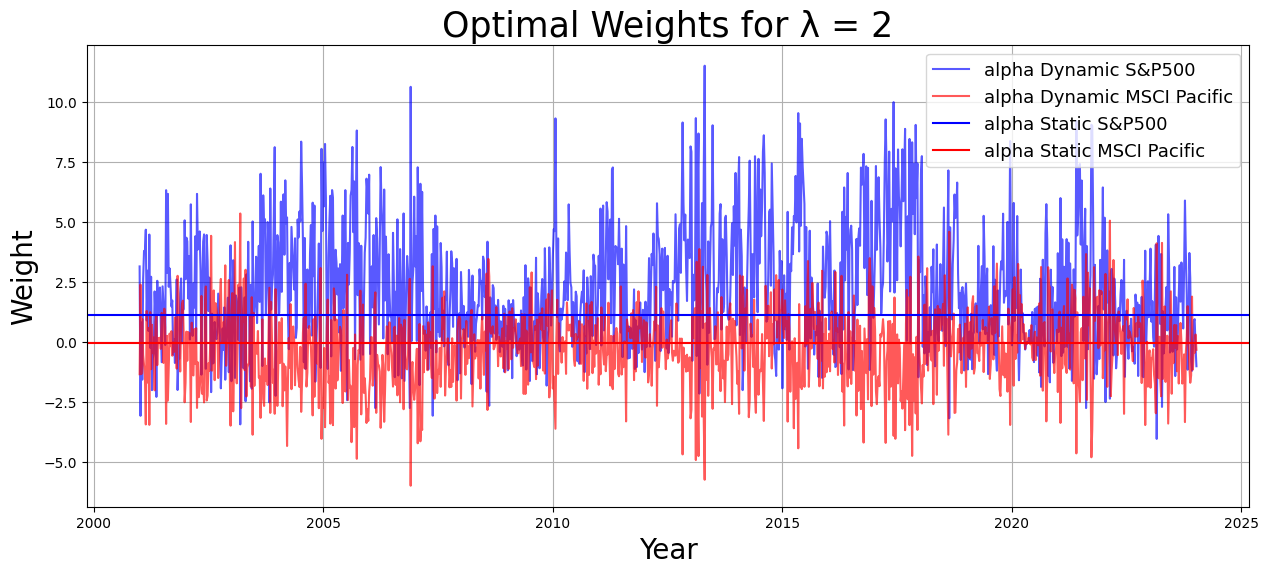

In [262]:
# Convert weeks to years
weeks = np.arange(len(alpha_opti_1))
years = 2001 + weeks / 52  # Assuming 52 weeks in a year

# Plotting optimal weights for λ = 2
plt.figure(figsize=(15, 6))
plt.plot(years,alpha_opti_1[:, 0, 0], label='alpha Dynamic S&P500', color='blue', alpha=0.65)
plt.plot(years,alpha_opti_1[:, 1, 0], label='alpha Dynamic MSCI Pacific', color='red', alpha=0.65)
plt.axhline(y=alpha_opti_1_static[0], color='blue', label='alpha Static S&P500')
plt.axhline(y=alpha_opti_1_static[1], color='red', label='alpha Static MSCI Pacific')
plt.title('Optimal Weights for λ = 2', fontsize=25)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Weight', fontsize=20)
plt.legend(fontsize=13)
plt.grid(True)
plt.show()

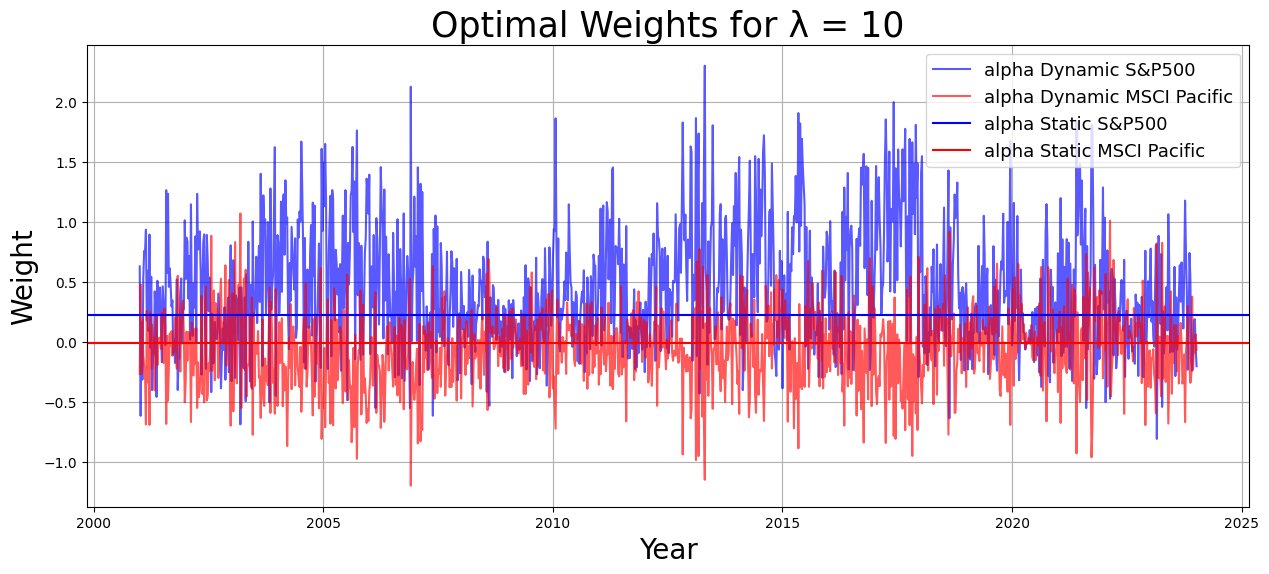

In [263]:
# Plotting optimal weights for λ = 10
plt.figure(figsize=(15, 6))
plt.plot(years,alpha_opti_2[:, 0, 0], label='alpha Dynamic S&P500', color='blue', alpha=0.65)
plt.plot(years,alpha_opti_2[:, 1, 0], label='alpha Dynamic MSCI Pacific', color='red', alpha=0.65)
plt.axhline(y=alpha_opti_2_static[0], color='blue', label='alpha Static S&P500')
plt.axhline(y=alpha_opti_2_static[1], color='red', label='alpha Static MSCI Pacific')
plt.title('Optimal Weights for λ = 10', fontsize=25)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Weight', fontsize=20)
plt.legend(fontsize=13)
plt.grid(True)
plt.show()

Q 3.2

In [264]:
# Setting portfolio return lists
portfolio_ret_static_λ_2=[]
portfolio_ret_static_λ_10=[]
portfolio_ret_dyn_λ_2=[]
portfolio_ret_dyn_λ_10=[]
# Setting cumulative return lists
cum_ret_static_λ_2=[]
cum_ret_static_λ_10=[]
cum_ret_dyn_λ_2=[]
cum_ret_dyn_λ_10=[]

################ Static Case ################

# cumulative return for λ= 2
cumulative_return = 1
for i in range(len(Weekly_simple_return)):
   portfolio_ret_static_λ_2.append(Weekly_simple_return.iloc[i,0]*alpha_opti_1_static[0]+Weekly_simple_return.iloc[i,1]*alpha_opti_1_static[1]+Weekly_simple_return.iloc[i,2]*alpha_Rf_1_static +1)
   cumulative_return = cumulative_return*portfolio_ret_static_λ_2[i]
   cum_ret_static_λ_2.append(cumulative_return)


# cumulative return for λ= 10
cumulative_return = 1
for i in range(len(Weekly_simple_return)):
   portfolio_ret_static_λ_10.append(Weekly_simple_return.iloc[i,0]*alpha_opti_2_static[0]+Weekly_simple_return.iloc[i,1]*alpha_opti_2_static[1]+Weekly_simple_return.iloc[i,2]*alpha_Rf_2_static +1)
   cumulative_return = cumulative_return*portfolio_ret_static_λ_10[i]
   cum_ret_static_λ_10.append(cumulative_return)


################ Dynamic Case ################

# cumulative return for λ= 2
cumulative_return = 1
for i in range(len(Weekly_simple_return[:-1])):
   portfolio_ret_dyn_λ_2.append(Weekly_simple_return.iloc[i+1,0]*alpha_opti_1[i][0]+Weekly_simple_return.iloc[i+1,1]*alpha_opti_1[i][1]+Weekly_simple_return.iloc[i+1,2]*alpha_Rf_1[i] +1)
   cumulative_return = cumulative_return*portfolio_ret_dyn_λ_2[i]
   cum_ret_dyn_λ_2.append(cumulative_return)   

# cumulative return for λ= 10
cumulative_return = 1
for i in range(len(Weekly_simple_return[:-1])):
   portfolio_ret_dyn_λ_10.append(Weekly_simple_return.iloc[i+1,0]*alpha_opti_2[i][0]+Weekly_simple_return.iloc[i+1,1]*alpha_opti_2[i][1]+Weekly_simple_return.iloc[i+1,2]*alpha_Rf_2[i] +1)
   cumulative_return = cumulative_return*portfolio_ret_dyn_λ_10[i]
   cum_ret_dyn_λ_10.append(cumulative_return) 


In [265]:
# Create DataFrames from each list
cum_ret_static_λ_2_df = pd.DataFrame({'Cum ret static λ=2': cum_ret_static_λ_2})
cum_ret_static_λ_10_df = pd.DataFrame({'Cum ret static λ=10': cum_ret_static_λ_10})
cum_ret_dyn_λ_2_df = pd.DataFrame({'Cum ret dyn λ=2': cum_ret_dyn_λ_2})
cum_ret_dyn_λ_10_df = pd.DataFrame({'Cum ret dyn λ=10': cum_ret_dyn_λ_10})
cum_ret_summary = pd.concat([cum_ret_static_λ_2_df, cum_ret_static_λ_10_df,cum_ret_dyn_λ_2_df,cum_ret_dyn_λ_10_df], axis=1)
cum_ret_summary = cum_ret_summary.astype(float)
cum_ret_summary = cum_ret_summary.drop(cum_ret_summary.index[-1])
cum_ret_summary

,Cum ret static λ=2,Cum ret static λ=10,Cum ret dyn λ=2,Cum ret dyn λ=10
0,0.979636,0.996833,1.118453,1.024614
1,1.000948,1.002091,1.191248,1.038892
2,1.019390,1.006704,1.225465,1.045829
3,1.038050,1.011328,1.229114,1.047337
4,1.030377,1.010689,1.181650,1.040129
...,...,...,...,...
1193,5.788158,2.076996,1204.803499,8.242185
1194,5.793701,2.079108,1209.499254,8.255413
1195,5.823674,2.082975,1222.613114,8.280129
1196,5.899686,2.090132,1223.072576,8.287585


Plot the cumulative portfolio returns

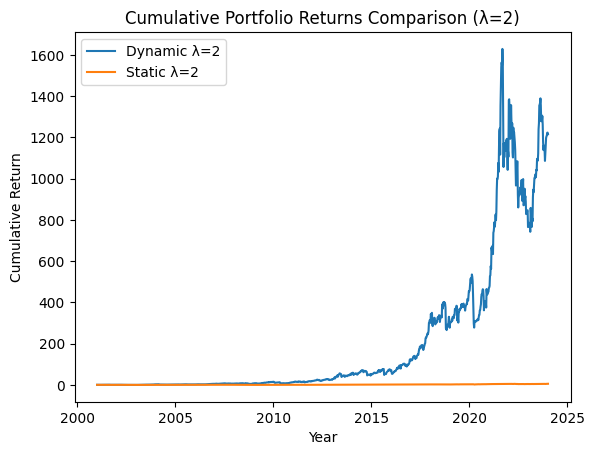

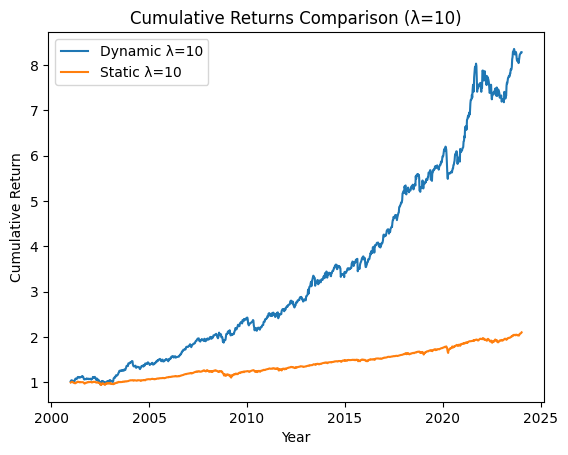

In [266]:
# Convert weeks to years
weeks = np.arange(len(cum_ret_summary))
years = 2001 + weeks / 52  

# Plotting cumulative returns for λ=2
plt.plot(years, cum_ret_summary['Cum ret dyn λ=2'], label='Dynamic λ=2')
plt.plot(years, cum_ret_summary['Cum ret static λ=2'], label='Static λ=2')

plt.title('Cumulative Portfolio Returns Comparison (λ=2)')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

# Plotting cumulative returns for λ=10
plt.plot(years, cum_ret_summary['Cum ret dyn λ=10'], label='Dynamic λ=10')
plt.plot(years, cum_ret_summary['Cum ret static λ=10'], label='Static λ=10')

plt.title('Cumulative Returns Comparison (λ=10)')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()


As we can see, cumulative return with  λ=2 in the dynamic case is explosive so we will do the log method :

In [267]:
# Setting portfolio return lists
portfolio_ret_static_λ_2_log=[]
portfolio_ret_static_λ_10_log=[]
portfolio_ret_dyn_λ_2_log=[]
portfolio_ret_dyn_λ_10_log=[]
# Setting cumulative return lists
cum_ret_static_λ_2_log=[]
cum_ret_static_λ_10_log=[]
cum_ret_dyn_λ_2_log=[]
cum_ret_dyn_λ_10_log=[]

################ Static Case ################

# cumulative return for λ= 2
cumulative_return = 1
for i in range(len(Weekly_simple_return)):
   portfolio_ret_static_λ_2_log.append(math.log(Weekly_simple_return.iloc[i,0]*alpha_opti_1_static[0,0]+Weekly_simple_return.iloc[i,1]*alpha_opti_1_static[1,0]+Weekly_simple_return.iloc[i,2]*alpha_Rf_1_static[0,0] +1))
   cumulative_return = cumulative_return + portfolio_ret_static_λ_2_log[i]
   cum_ret_static_λ_2_log.append(cumulative_return)


# cumulative return for λ= 10
cumulative_return = 1
for i in range(len(Weekly_simple_return)):
   portfolio_ret_static_λ_10_log.append(math.log(Weekly_simple_return.iloc[i,0]*alpha_opti_2_static[0,0]+Weekly_simple_return.iloc[i,1]*alpha_opti_2_static[1,0]+Weekly_simple_return.iloc[i,2]*alpha_Rf_2_static[0,0] +1))
   cumulative_return = cumulative_return + portfolio_ret_static_λ_10_log[i]
   cum_ret_static_λ_10_log.append(cumulative_return)


################ Dynamic Case ################

# cumulative return for λ= 2
cumulative_return = 1
for i in range(len(Weekly_simple_return[:-1])):
   portfolio_ret_dyn_λ_2_log.append(math.log(Weekly_simple_return.iloc[i+1,0]*alpha_opti_1[i,0][0]+Weekly_simple_return.iloc[i+1,1]*alpha_opti_1[i][1,0]+Weekly_simple_return.iloc[i+1,2]*alpha_Rf_1[i][0,0] +1))
   cumulative_return = cumulative_return + portfolio_ret_dyn_λ_2_log[i]
   cum_ret_dyn_λ_2_log.append(cumulative_return)   

# cumulative return for λ= 10
cumulative_return = 1
for i in range(len(Weekly_simple_return[:-1])):
   portfolio_ret_dyn_λ_10_log.append(math.log(Weekly_simple_return.iloc[i+1,0]*alpha_opti_2[i,0][0]+Weekly_simple_return.iloc[i+1,1]*alpha_opti_2[i][1,0]+Weekly_simple_return.iloc[i+1,2]*alpha_Rf_2[i][0,0] +1))
   cumulative_return = cumulative_return + portfolio_ret_dyn_λ_10_log[i]
   cum_ret_dyn_λ_10_log.append(cumulative_return) 

In [268]:
# Create DataFrames from each list
cum_ret_static_λ_2_log_df = pd.DataFrame({'Cum ret static λ=2 (log)': cum_ret_static_λ_2_log})
cum_ret_static_λ_10_log_df = pd.DataFrame({'Cum ret static λ=10 (log)': cum_ret_static_λ_10_log})
cum_ret_dyn_λ_2_log_df = pd.DataFrame({'Cum ret dyn λ=2 (log)': cum_ret_dyn_λ_2_log})
cum_ret_dyn_λ_10_log_df = pd.DataFrame({'Cum ret dyn λ=10 (log)': cum_ret_dyn_λ_10_log})
cum_ret_summary_2 = pd.concat([cum_ret_static_λ_2_log_df, cum_ret_static_λ_10_log_df,cum_ret_dyn_λ_2_log_df,cum_ret_dyn_λ_10_log_df], axis=1)
cum_ret_summary_2.astype(float)
cum_ret_summary_2 = cum_ret_summary_2.drop(cum_ret_summary_2.index[-1])
cum_ret_summary_2

,Cum ret static λ=2 (log),Cum ret static λ=10 (log),Cum ret dyn λ=2 (log),Cum ret dyn λ=10 (log)
0,0.979425,0.996828,1.111947,1.024316
1,1.000948,1.002089,1.175002,1.038155
2,1.019205,1.006681,1.203321,1.044810
3,1.037344,1.011265,1.206294,1.046251
4,1.029925,1.010632,1.166912,1.039345
...,...,...,...,...
1193,2.755814,1.730923,8.094072,3.109265
1194,2.756771,1.731939,8.097962,3.110869
1195,2.761931,1.733797,8.108746,3.113858
1196,2.774899,1.737227,8.109121,3.114759


Plot the cumulative portfolio returns with the log method

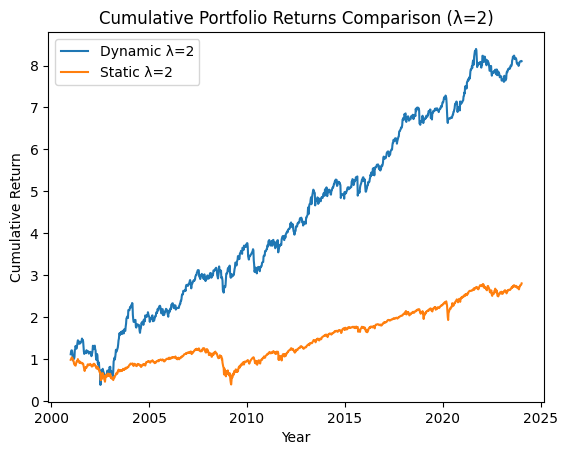

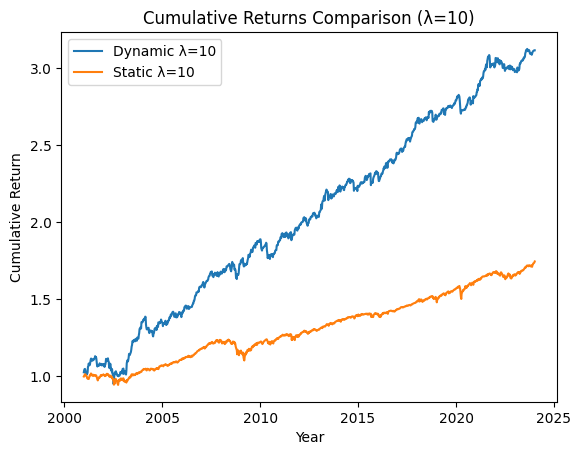

In [269]:

# Plotting cumulative returns for λ=2
plt.plot(years, cum_ret_summary_2['Cum ret dyn λ=2 (log)'], label='Dynamic λ=2')
plt.plot(years, cum_ret_summary_2['Cum ret static λ=2 (log)'], label='Static λ=2')

plt.title('Cumulative Portfolio Returns Comparison (λ=2)')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

# Plotting cumulative returns for λ=10
plt.plot(years, cum_ret_summary_2['Cum ret dyn λ=10 (log)'], label='Dynamic λ=10')
plt.plot(years, cum_ret_summary_2['Cum ret static λ=10 (log)'], label='Static λ=10')

plt.title('Cumulative Returns Comparison (λ=10)')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()


Q 3.3

f value for λ=2 :

In [270]:
alpha_opti_1_shifted = np.concatenate((np.zeros_like(alpha_opti_1[0])[np.newaxis], alpha_opti_1[:-1]), axis=0)
# Objective function to minimize
def objective_function(f):
    trans_cost = (np.abs(alpha_opti_1[:, 0] - alpha_opti_1_shifted[:, 0]) + np.abs(alpha_opti_1[:, 1] - alpha_opti_1_shifted[:, 1])) * f
    lhs = np.sum(trans_cost) + cum_ret_summary['Cum ret static λ=2'].iloc[-1]
    rhs = cum_ret_summary['Cum ret dyn λ=2'].iloc[-1]
    return (lhs - rhs)**2  # We square the difference to ensure a non-negative objective function

# Find the value of f that minimizes the objective function
result = minimize_scalar(objective_function)

# Extract the optimal value of f
optimal_f = result.x

print("Value of f for λ=2:", optimal_f)

Value of f for λ=2: 0.24077742334036037


f value for λ=10:

In [271]:
alpha_opti_2_shifted = np.concatenate((np.zeros_like(alpha_opti_2[0])[np.newaxis], alpha_opti_2[:-1]), axis=0)
# Objective function to minimize
def objective_function_2(f):
    trans_cost = (np.abs(alpha_opti_2[:, 0] - alpha_opti_2_shifted[:, 0]) + np.abs(alpha_opti_2[:, 1] - alpha_opti_2_shifted[:, 1])) * f
    lhs = np.sum(trans_cost) + cum_ret_summary['Cum ret static λ=10'].iloc[-1]
    rhs = cum_ret_summary['Cum ret dyn λ=10'].iloc[-1]
    return (lhs - rhs)**2  # We square the difference to ensure a non-negative objective function

# Find the value of f that minimizes the objective function
result = minimize_scalar(objective_function_2)

# Extract the optimal value of f
optimal_f_2 = result.x

print("Value of f for λ=10:", optimal_f_2)

Value of f for λ=10: 0.006153541002879007


# 4 Computing the VaR of a portfolio

In [272]:

# Rename column
data_2 = data_2.rename(columns={'S&P 500 COMPOSITE - TOT RETURN IND': 'SP500','MSCI PACIFIC U$ - TOT RETURN IND':'MSCI P','US DOLLAR S/T DEPOSIT (FT/RFV) - MIDDLE RATE':'US RATE annualized'})
# Set date as index
data_2['Date'] = pd.to_datetime(data_2['Date'])         
data_2.set_index('Date', inplace=True)
# Divide risk-free rate by 100 since it's in %
data_2['US RATE annualized']=data_2['US RATE annualized']/100

data_2

,SP500,MSCI P,US RATE annualized
Date,,,
2001-01-01,1837.36,3250.437,0.066875
2001-01-02,1785.86,3245.715,0.067031
2001-01-03,1875.56,3240.940,0.064688
2001-01-04,1855.82,3238.871,0.060469
2001-01-05,1807.13,3259.726,0.059531
...,...,...,...
2023-12-25,10292.37,9150.464,0.053650
2023-12-26,10335.98,9144.594,0.053650
2023-12-27,10351.60,9265.377,0.053650


In [273]:
#Setting DataFrame
Daily_simple_return = pd.DataFrame()
# Simple returns for stocks and bonds
for column in data_2.columns[:-1]:
    new_column_name = f'Daily_simple_return_{column}'
    Daily_simple_return[new_column_name] = data_2[column].pct_change()
#Simple return for risk-free rate
Daily_simple_return['US RATE'] = data_2['US RATE annualized']/360 # Since it's annualized
# Drop 5 first rows since the investment begin at 2001-01-08
Daily_simple_return 

,Daily_simple_return_SP500,Daily_simple_return_MSCI P,US RATE
Date,,,
2001-01-01,NaN,NaN,0.000186
2001-01-02,-0.028029,-0.001453,0.000186
2001-01-03,0.050228,-0.001471,0.000180
2001-01-04,-0.010525,-0.000638,0.000168
2001-01-05,-0.026236,0.006439,0.000165
...,...,...,...
2023-12-25,0.000000,0.000670,0.000149
2023-12-26,0.004237,-0.000641,0.000149
2023-12-27,0.001511,0.013208,0.000149


Compute daily static portfolio returns

In [274]:
daily_port_ret_λ_2 = Daily_simple_return['Daily_simple_return_SP500']*alpha_opti_1_static[0]+Daily_simple_return['Daily_simple_return_MSCI P']*alpha_opti_1_static[1]+Daily_simple_return['US RATE']*alpha_Rf_1_static[0,0]
daily_port_ret_λ_10 = Daily_simple_return['Daily_simple_return_SP500']*alpha_opti_2_static[0]+Daily_simple_return['Daily_simple_return_MSCI P']*alpha_opti_2_static[1]+Daily_simple_return['US RATE']*alpha_Rf_2_static[0,0]

Daily_static_port_ret_df = pd.DataFrame({'Daily static portfolio return for λ=2': daily_port_ret_λ_2 , 'Daily static portfolio return for λ=10':daily_port_ret_λ_10})[6:-4]
Daily_static_port_ret_df
# We removed data from 2001-01-01 to 2001-01-08 and from 2023-12-25 to 2023-12-29
# to keep consistency with the dynamic portfolio

,Daily static portfolio return for λ=2,Daily static portfolio return for λ=10
Date,,
2001-01-09,0.005065,0.001145
2001-01-10,0.011288,0.002391
2001-01-11,0.012726,0.002679
2001-01-12,-0.007296,-0.001327
2001-01-15,0.000003,0.000134
...,...,...
2023-12-19,0.006360,0.001391
2023-12-20,-0.016689,-0.003219
2023-12-21,0.011548,0.002429


Compute daily dynamic portfolio returns

In [275]:
#Set new variables
Dsr = Daily_simple_return[6:] # Drop first days since the investment begin at 2001-01-08 at night
Dsr_group = []
Dsr_group_df = pd.DataFrame()
# Reset index to convert date index into a regular column
Dsr.reset_index(inplace=True)
# Convert 'Date' column to datetime
Dsr.loc[:,'Date'] = pd.to_datetime(Dsr['Date'])
# Group daily returns by weeks
for i in Dsr.columns[1:]:
    Dsr_grouped = pd.DataFrame({f"{i}_grouped":Dsr.groupby(pd.Grouper(key='Date', freq='W-MON'))[i].apply(list) })
    Dsr_group.append(Dsr_grouped)
# transform element of the list to a dataframe    
for i in range(3):
    Dsr_group_df[i] = Dsr_group[i]
# Change columns name
Dsr_group_df = Dsr_group_df.rename(columns={0:'Daily_simple_return_SP500_grouped',
                                            1:'Daily_simple_return_MSCI P_grouped',
                                            2:'US RATE_grouped'})
Dsr_group_df = Dsr_group_df[:-1] # Because investment stop 2023-12-25

In [276]:
Daily_dyn_port_ret_λ_2 = []
Daily_dyn_port_ret_λ_10=[]

for i in range(len(alpha_opti_1)):
    # Change variables for clarity
    sp500_ret = Dsr_group_df['Daily_simple_return_SP500_grouped'].iloc[i]
    msci_ret = Dsr_group_df['Daily_simple_return_MSCI P_grouped'].iloc[i]
    us_ret = Dsr_group_df['US RATE_grouped'].iloc[i]

    w_sp500 = alpha_opti_1[i, 0]
    w_msci = alpha_opti_1[i, 1]
    w_rf = alpha_Rf_1[i][0,0]

    w_sp500_2 = alpha_opti_2[i, 0]
    w_msci_2 = alpha_opti_2[i, 1]
    w_rf_2 = alpha_Rf_2[i][0,0]

    # Compute daily dyn portfolio returns for λ=2
    dpr = [sp*w_sp500 + msci*w_msci + us*w_rf for sp,msci,us in zip(sp500_ret, msci_ret, us_ret)]
    Daily_dyn_port_ret_λ_2.append(dpr)

    # Compute daily dyn portfolio returns  λ=10
    dpr_2 = [sp*w_sp500_2 + msci*w_msci_2 + us*w_rf_2 for sp,msci,us in zip(sp500_ret, msci_ret, us_ret)]
    Daily_dyn_port_ret_λ_10.append(dpr_2)


In [277]:
# Extract the values and create a dataframe
Daily_dyn_port_ret_λ_2_tr = [item for sublist in Daily_dyn_port_ret_λ_2 for item in sublist]
Daily_dyn_port_ret_λ_10_tr = [item for sublist in Daily_dyn_port_ret_λ_10 for item in sublist]
Daily_dyn_port_ret_df = pd.DataFrame({'Daily dynamic portfolio return for λ=2': Daily_dyn_port_ret_λ_2_tr , 'Daily dynamic portfolio return for λ=10':Daily_dyn_port_ret_λ_10_tr})
for column in Daily_dyn_port_ret_df.columns:
    Daily_dyn_port_ret_df[column] = Daily_dyn_port_ret_df[column].apply(lambda x: x[0])
Daily_dyn_port_ret_df.index = Daily_static_port_ret_df.index    
Daily_dyn_port_ret_df

,Daily dynamic portfolio return for λ=2,Daily dynamic portfolio return for λ=10
Date,,
2001-01-09,0.033626,0.006857
2001-01-10,0.043288,0.008791
2001-01-11,0.065522,0.013238
2001-01-12,-0.023175,-0.004503
2001-01-15,0.000298,0.000193
...,...,...
2023-12-19,-0.007841,-0.001449
2023-12-20,0.012758,0.002671
2023-12-21,-0.010119,-0.001905


In [278]:
# Define Loss
L_stat_λ_2 = -Daily_static_port_ret_df['Daily static portfolio return for λ=2']
L_stat_λ_10 = -Daily_static_port_ret_df['Daily static portfolio return for λ=10']
L_dyn_λ_2 = -Daily_dyn_port_ret_df['Daily dynamic portfolio return for λ=2']
L_dyn_λ_10 = -Daily_dyn_port_ret_df['Daily dynamic portfolio return for λ=10']
#Create a Dataframe
L_df = pd.DataFrame({'Loss static port return λ=2': L_stat_λ_2 ,
                     'Loss static port return λ=10':L_stat_λ_10,
                     'Loss dyn port return λ=2': L_dyn_λ_2,
                     'Loss dyn port return λ=10':L_dyn_λ_10
                    })
L_df

,Loss static port return λ=2,Loss static port return λ=10,Loss dyn port return λ=2,Loss dyn port return λ=10
Date,,,,
2001-01-09,-0.005065,-0.001145,-0.033626,-0.006857
2001-01-10,-0.011288,-0.002391,-0.043288,-0.008791
2001-01-11,-0.012726,-0.002679,-0.065522,-0.013238
2001-01-12,0.007296,0.001327,0.023175,0.004503
2001-01-15,-0.000003,-0.000134,-0.000298,-0.000193
...,...,...,...,...
2023-12-19,-0.006360,-0.001391,0.007841,0.001449
2023-12-20,0.016689,0.003219,-0.012758,-0.002671
2023-12-21,-0.011548,-0.002429,0.010119,0.001905


Q4.1

In [279]:
L_mean = {}
L_var =  {}
# Compute the unconditional mean
for i in L_df.columns:
    L_mean[i] = L_df[i].mean()
    L_var[i] = L_df[i].var()
L_mean_df = pd.DataFrame.from_dict(L_mean, orient='index', columns=['Mean'])
L_var_df = pd.DataFrame.from_dict(L_var, orient='index', columns=['Var'])
L_moments = pd.concat([L_mean_df, L_var_df], axis=1)

In [280]:
L_df

,Loss static port return λ=2,Loss static port return λ=10,Loss dyn port return λ=2,Loss dyn port return λ=10
Date,,,,
2001-01-09,-0.005065,-0.001145,-0.033626,-0.006857
2001-01-10,-0.011288,-0.002391,-0.043288,-0.008791
2001-01-11,-0.012726,-0.002679,-0.065522,-0.013238
2001-01-12,0.007296,0.001327,0.023175,0.004503
2001-01-15,-0.000003,-0.000134,-0.000298,-0.000193
...,...,...,...,...
2023-12-19,-0.006360,-0.001391,0.007841,0.001449
2023-12-20,0.016689,0.003219,-0.012758,-0.002671
2023-12-21,-0.011548,-0.002429,0.010119,0.001905


In [281]:
L_moments

,Mean,Var
Loss static port return λ=2,-0.000392,0.000180
Loss static port return λ=10,-0.000115,0.000007
Loss dyn port return λ=2,-0.001601,0.001113
Loss dyn port return λ=10,-0.000357,0.000045


Compute the value at risk

In [282]:
# Set parameters
theta = 0.99
z = norm.ppf(theta) # assuming normal distribution
VaR_99 = []
# Compute unconditional VaR
for i in range(4):
    VaR_99.append(L_moments['Mean'].iloc[i]+z*np.sqrt(L_moments['Var'].iloc[i]))
VaR_99_df = pd.DataFrame(VaR_99, index=L_df.columns, columns=['VaR_99'])
VaR_99_df
    

,VaR_99
Loss static port return λ=2,0.030823
Loss static port return λ=10,0.006127
Loss dyn port return λ=2,0.076025
Loss dyn port return λ=10,0.015168


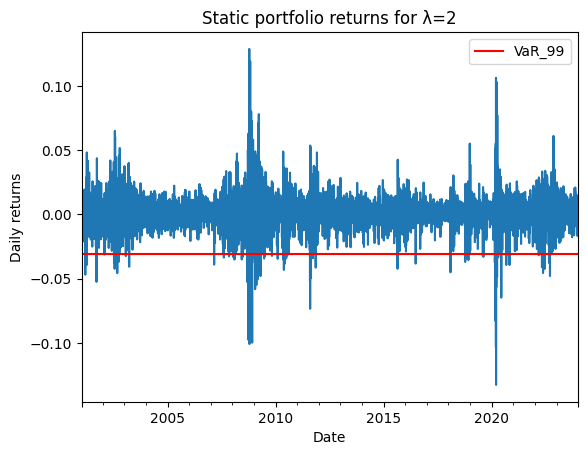

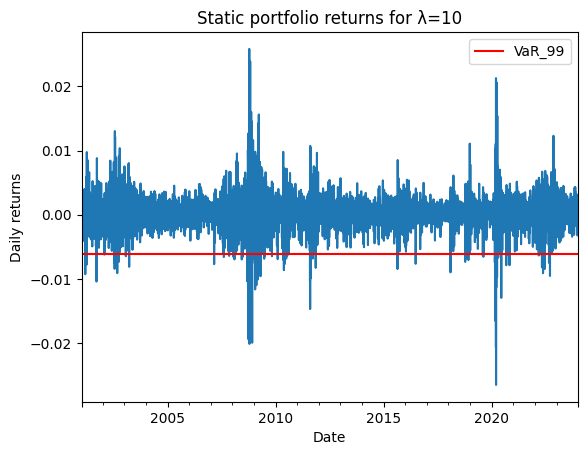

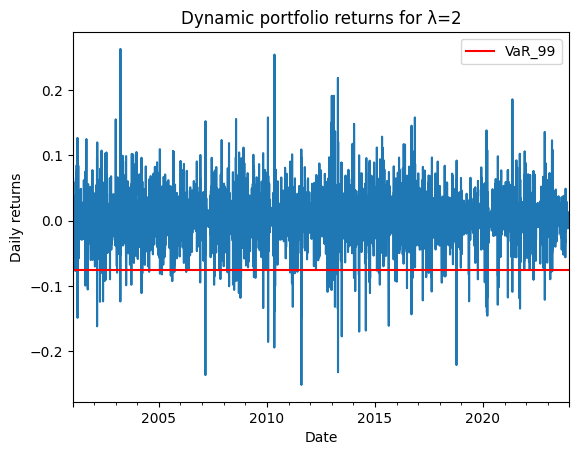

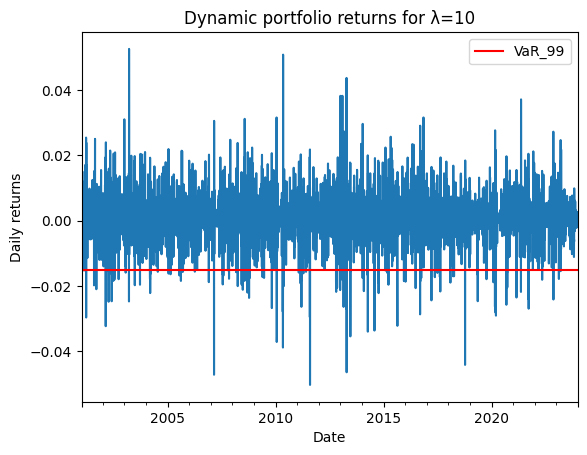

In [283]:
# Plot Portfolio returns + VaR

# Static λ=2
plt.figure()
Daily_static_port_ret_df['Daily static portfolio return for λ=2'].plot(kind='line', title='Static portfolio returns for λ=2',label='_nolegend_')
plt.xlabel('Date')
plt.ylabel('Daily returns')
plt.axhline(y=-VaR_99_df['VaR_99'].iloc[0], color='r', label='VaR_99')
plt.legend()
plt.show()

# Static λ=10
plt.figure()
Daily_static_port_ret_df['Daily static portfolio return for λ=10'].plot(kind='line', title='Static portfolio returns for λ=10',label='_nolegend_')
plt.xlabel('Date')
plt.ylabel('Daily returns')
plt.axhline(y=-VaR_99_df['VaR_99'].iloc[1], color='r', label='VaR_99')
plt.legend()
plt.show()

# Dynamic λ=2
plt.figure()
Daily_dyn_port_ret_df['Daily dynamic portfolio return for λ=2'].plot(kind='line', title='Dynamic portfolio returns for λ=2',label='_nolegend_')
plt.xlabel('Date')
plt.ylabel('Daily returns')
plt.axhline(y=-VaR_99_df['VaR_99'].iloc[2], color='r', label='VaR_99')
plt.legend()
plt.show()

# Dynamic λ=10
plt.figure()
Daily_dyn_port_ret_df['Daily dynamic portfolio return for λ=10'].plot(kind='line', title='Dynamic portfolio returns for λ=10',label='_nolegend_')
plt.xlabel('Date')
plt.ylabel('Daily returns')
plt.axhline(y=-VaR_99_df['VaR_99'].iloc[3], color='r', label='VaR_99')
plt.legend()
plt.show()

Q4.2

In [284]:
# Initialize a list to store AR residuals
L_AR_res = []
L_garch_param=[]
L_garch_results =[]
L_cond_volat=[]
L_garch_resi = []
L_AR_param = {'Column': [], 'Intercept': [], 'Coefficient': []}
for column in L_df.columns:
  
    # Estimate AR(1) model
    y = L_df[column].dropna() 
    X = L_df[column].shift(1).dropna() 
    y = y.drop(y.index[0]) 
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    # Print the summary
    print(f"AR(1) results for column {column}:")
    print(model.summary())

    # Extract parameters (coefficients)
    intercept, coef_rt_1 = model.params
    L_AR_param['Column'].append(column)
    L_AR_param['Intercept'].append(intercept)
    L_AR_param['Coefficient'].append(coef_rt_1)



    # Calculate residuals
    residuals = pd.DataFrame({f"{column}_residuals": model.resid})

    #Estimate GARCH(1,1) on residuals
    model_2 = arch.arch_model(residuals*1000, vol='Garch', p=1, o=0, q=1, dist='Normal')
    res = model_2.fit()
    L_garch_results.append(res.summary())

    # Extract GARCH parameters and store in a dictionary
    params_dict = {
        'Column': column,
        'Omega': res.params['omega']/1000**2, # Rescale omega by 100^2
        'Alpha': res.params['alpha[1]'],
        'Beta': res.params['beta[1]']
    }
    # Append parameters dictionary to the list
    L_garch_param.append(params_dict)

    # compute conditional volatility of the model
    L_cond_volat.append(res.conditional_volatility/1000) 
    L_garch_resi.append(res.resid/1000)


# Convert ar parameters to DataFrame
L_AR_param_df = pd.DataFrame(L_AR_param)    

# Create a Dataframe to print the garch parameters 
L_garch_param_df = pd.DataFrame(L_garch_param)
L_garch_param_df.set_index(L_garch_param_df.columns[0], inplace=True)
L_garch_param_df = L_garch_param_df.astype(float)     

AR(1) results for column Loss static port return λ=2:
                                 OLS Regression Results                                
Dep. Variable:     Loss static port return λ=2   R-squared:                       0.017
Model:                                     OLS   Adj. R-squared:                  0.017
Method:                          Least Squares   F-statistic:                     102.8
Date:                         Thu, 23 May 2024   Prob (F-statistic):           5.87e-24
Time:                                 21:22:32   Log-Likelihood:                 17372.
No. Observations:                         5989   AIC:                        -3.474e+04
Df Residuals:                             5987   BIC:                        -3.473e+04
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                                  coef    std err          t      

In [285]:
# The "true" parameters for the garch model
L_garch_param_df

,Omega,Alpha,Beta
Column,,,
Loss static port return λ=2,2.617380e-06,0.114817,0.868680
Loss static port return λ=10,1.050583e-07,0.114622,0.868765
Loss dyn port return λ=2,1.780336e-04,0.367908,0.520910
Loss dyn port return λ=10,7.114717e-06,0.368238,0.520845


In [286]:
L_garch_results # Note that the parameters are not rescaled

[<class 'statsmodels.iolib.summary.Summary'>
 """
                                Constant Mean - GARCH Model Results                               
 Dep. Variable:     Loss static port return λ=2_residuals   R-squared:                       0.000
 Mean Model:                                Constant Mean   Adj. R-squared:                  0.000
 Vol Model:                                         GARCH   Log-Likelihood:               -22506.9
 Distribution:                                     Normal   AIC:                           45021.9
 Method:                               Maximum Likelihood   BIC:                           45048.7
                                                            No. Observations:                 5989
 Date:                                   Thu, May 23 2024   Df Residuals:                     5988
 Time:                                           21:22:33   Df Model:                            1
                                Mean Model                 

Forecasts

In [287]:
L_exp_mean = pd.DataFrame()
L_exp_var = pd.DataFrame()
for i, column in enumerate(L_df.columns):
    L_exp_mean["exp "+column] = L_df[column].shift(1) * L_AR_param_df['Coefficient'][i] + L_AR_param_df['Intercept'][i]
for i, column in enumerate(L_df.columns):
    L_exp_var["exp var "+column] = L_cond_volat[i]**2   
L_exp_mean = L_exp_mean.dropna()
L_exp_var = L_exp_var.dropna()
L_exp_mean


,exp Loss static port return λ=2,exp Loss static port return λ=10,exp Loss dyn port return λ=2,exp Loss dyn port return λ=10
Date,,,,
2001-01-10,0.000216,0.000019,0.003282,0.000635
2001-01-11,0.001024,0.000181,0.004754,0.000929
2001-01-12,0.001211,0.000219,0.008140,0.001607
2001-01-15,-0.001390,-0.000303,-0.005369,-0.001097
2001-01-16,-0.000442,-0.000113,-0.001794,-0.000381
...,...,...,...,...
2023-12-19,0.000296,0.000033,-0.002549,-0.000534
2023-12-20,0.000384,0.000051,-0.003034,-0.000631
2023-12-21,-0.002610,-0.000549,0.000104,-0.000003


In [288]:
L_exp_var

,exp var Loss static port return λ=2,exp var Loss static port return λ=10,exp var Loss dyn port return λ=2,exp var Loss dyn port return λ=10
Date,,,,
2001-01-10,0.000125,0.000005,0.001148,0.000046
2001-01-11,0.000125,0.000005,0.001538,0.000062
2001-01-12,0.000131,0.000005,0.002743,0.000111
2001-01-15,0.000122,0.000005,0.001702,0.000069
2001-01-16,0.000109,0.000004,0.001078,0.000043
...,...,...,...,...
2023-12-19,0.000055,0.000002,0.000393,0.000016
2023-12-20,0.000055,0.000002,0.000431,0.000017
2023-12-21,0.000083,0.000003,0.000430,0.000017


Temporal conditional quantile θ = 99%

In [289]:
# Set empty list
cond_q_stat_λ_2=[]
cond_q_stat_λ_10=[]
cond_q_dyn_λ_2=[]
cond_q_dyn_λ_10=[]
# Compute and store quantile in the lists
# Note : We assume normality
for i in range(len(L_exp_mean['exp Loss static port return λ=2'])):

    mean = L_exp_mean.iloc[i] 
    std_dev = L_exp_var.iloc[i]**0.5
    cond_q_stat_λ_2.append(norm.ppf(theta,loc=mean.iloc[0],scale=std_dev.iloc[0]))
    cond_q_stat_λ_10.append(norm.ppf(theta,loc=mean.iloc[1],scale=std_dev.iloc[1]))
    cond_q_dyn_λ_2.append(norm.ppf(theta,loc=mean.iloc[2],scale=std_dev.iloc[2]))
    cond_q_dyn_λ_10.append(norm.ppf(theta,loc=mean.iloc[3],scale=std_dev.iloc[3]))
# Transform into a Dataframe
cond_q = {
    'cond_q_stat_λ_2': cond_q_stat_λ_2,
    'cond_q_stat_λ_10': cond_q_stat_λ_10,
    'cond_q_dyn_λ_2': cond_q_dyn_λ_2,
    'cond_q_dyn_λ_10': cond_q_dyn_λ_10
}
cond_q_df = pd.DataFrame(cond_q, index=L_exp_mean.index)

In [290]:
cond_q_df

,cond_q_stat_λ_2,cond_q_stat_λ_10,cond_q_dyn_λ_2,cond_q_dyn_λ_10
Date,,,,
2001-01-10,0.026173,0.005236,0.082094,0.016446
2001-01-11,0.027019,0.005432,0.095997,0.019311
2001-01-12,0.027885,0.005631,0.129971,0.026155
2001-01-15,0.024273,0.004884,0.090600,0.018181
2001-01-16,0.023813,0.004784,0.074598,0.014934
...,...,...,...,...
2023-12-19,0.017594,0.003585,0.043559,0.008655
2023-12-20,0.017652,0.003606,0.045251,0.008965
2023-12-21,0.018535,0.003707,0.048351,0.009647


Temporal evolution of the conditional VaR θ = 99%

In [291]:
# Set empty list
cond_VaR_stat_λ_2=[]
cond_VaR_stat_λ_10=[]
cond_VaR_dyn_λ_2=[]
cond_VaR_dyn_λ_10=[]
for i in range(len(L_exp_mean['exp Loss static port return λ=2'])):

    # Set parameters
    q = cond_q_df.iloc[i]
    loss_t = L_df.iloc[i]
    loss_static_λ_2 = L_df['Loss static port return λ=2']
    loss_static_λ_10 = L_df['Loss static port return λ=10']
    loss_dyn_λ_2 = L_df['Loss dyn port return λ=2']
    loss_dyn_λ_10 = L_df['Loss dyn port return λ=10']


    #filter to get losses above q and compute the mean to get the condition VaR
    cond_VaR_stat_λ_2.append(loss_static_λ_2[loss_static_λ_2 > q.iloc[0]].mean())
    cond_VaR_stat_λ_10.append(loss_static_λ_10[loss_static_λ_10 > q.iloc[1]].mean())
    cond_VaR_dyn_λ_2.append(loss_dyn_λ_2[loss_dyn_λ_2 > q.iloc[2]].mean())
    cond_VaR_dyn_λ_10.append(loss_dyn_λ_10[loss_dyn_λ_10 > q.iloc[3]].mean())

# Transform into a Dataframe
cond_VaR = {
    'cond_VaR_stat_λ_2': cond_VaR_stat_λ_2,
    'cond_VaR_stat_λ_10': cond_VaR_stat_λ_10,
    'cond_VaR_dyn_λ_2': cond_VaR_dyn_λ_2,
    'cond_VaR_dyn_λ_10': cond_VaR_dyn_λ_10
}
cond_VaR_df = pd.DataFrame(cond_VaR, index=L_exp_mean.index)

In [292]:
cond_VaR_df

,cond_VaR_stat_λ_2,cond_VaR_stat_λ_10,cond_VaR_dyn_λ_2,cond_VaR_dyn_λ_10
Date,,,,
2001-01-10,0.039283,0.007853,0.113017,0.022571
2001-01-11,0.040222,0.008129,0.131619,0.026410
2001-01-12,0.041617,0.008428,0.166965,0.033373
2001-01-15,0.037013,0.007418,0.121516,0.024579
2001-01-16,0.036418,0.007298,0.104882,0.020942
...,...,...,...,...
2023-12-19,0.029161,0.005912,0.073927,0.014751
2023-12-20,0.029190,0.005943,0.075596,0.015052
2023-12-21,0.030375,0.006081,0.078971,0.015705


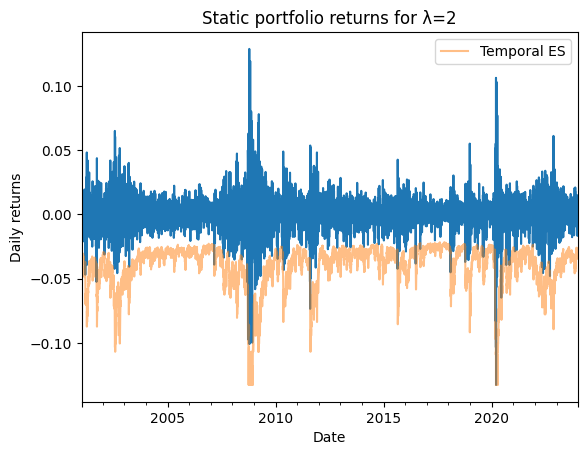

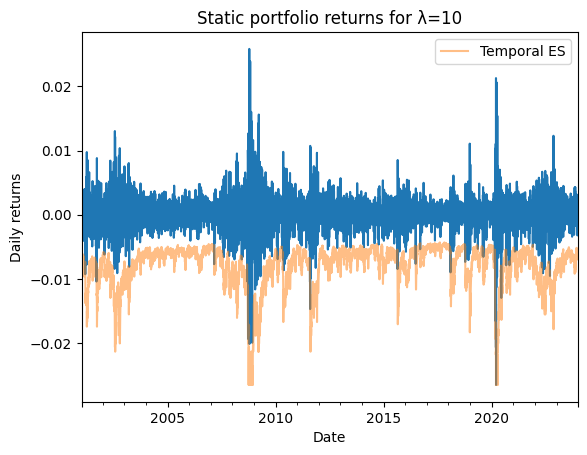

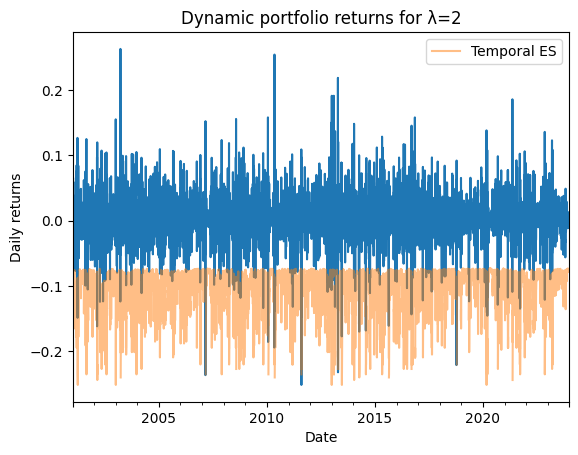

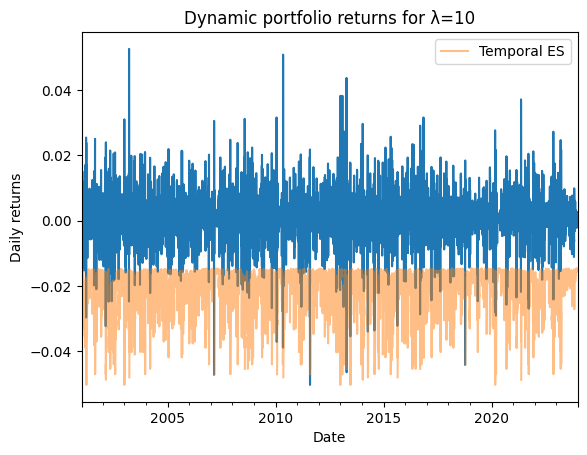

In [293]:
# Plot Portfolio returns + temporal conditional VaR GARCH

# Static λ=2
plt.figure()
Daily_static_port_ret_df['Daily static portfolio return for λ=2'].plot(kind='line', title='Static portfolio returns for λ=2',label='_nolegend_')
(-cond_VaR_df['cond_VaR_stat_λ_2']).plot(label='Temporal ES',alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Daily returns')
plt.legend()
plt.show()

# Static λ=10
plt.figure()
Daily_static_port_ret_df['Daily static portfolio return for λ=10'].plot(kind='line', title='Static portfolio returns for λ=10',label='_nolegend_')
(-cond_VaR_df['cond_VaR_stat_λ_10']).plot(label='Temporal ES',alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Daily returns')
plt.legend()
plt.show()

# Dynamic λ=2
plt.figure()
Daily_dyn_port_ret_df['Daily dynamic portfolio return for λ=2'].plot(kind='line', title='Dynamic portfolio returns for λ=2',label='_nolegend_')
(-cond_VaR_df['cond_VaR_dyn_λ_2']).plot(label='Temporal ES',alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Daily returns')
plt.legend()
plt.show()

# Dynamic λ=10
plt.figure()
Daily_dyn_port_ret_df['Daily dynamic portfolio return for λ=10'].plot(kind='line', title='Dynamic portfolio returns for λ=10',label='_nolegend_')
(-cond_VaR_df['cond_VaR_dyn_λ_10']).plot(label='Temporal ES',alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Daily returns')
plt.legend()
plt.show()

Q4.3

In [294]:
# Compute the standardized residuals
std_resi = (L_df[1:].values - L_exp_mean.values) / (L_exp_var.values)**0.5
std_resi[0:10]
std_resi_df = pd.DataFrame(std_resi, index=L_exp_mean.index)
std_resi_df.columns = ['std_res_static_λ_2', 'std_res_static_λ_10','std_res_dyn_λ_2','std_res_dyn_λ_10']
std_resi_df

,std_res_static_λ_2,std_res_static_λ_10,std_res_dyn_λ_2,std_res_dyn_λ_10
Date,,,,
2001-01-10,-1.030960,-1.074361,-1.374656,-1.386793
2001-01-11,-1.230506,-1.266997,-1.791753,-1.792962
2001-01-12,0.530683,0.476331,0.287094,0.274428
2001-01-15,0.125732,0.075734,0.122923,0.109035
2001-01-16,-0.548566,-0.596713,-0.714594,-0.730280
...,...,...,...,...
2023-12-19,-0.895145,-0.933229,0.524249,0.502084
2023-12-20,2.196504,2.072760,-0.468490,-0.494448
2023-12-21,-0.983290,-1.027535,0.482904,0.459935


In [307]:
# Take the maximum residual in each quarters
max_std_resid_Q = std_resi_df.resample('QE').max()
max_std_resid_Q

# Note : We divide into quarterly data by using the date and didn't split into 60 days groups exactly


,std_res_static_λ_2,std_res_static_λ_10,std_res_dyn_λ_2,std_res_dyn_λ_10
Date,,,,
2001-03-31,3.701207,3.701131,2.831901,2.821005
2001-06-30,2.306443,2.290582,2.357933,2.352927
2001-09-30,4.732258,4.739267,5.050170,5.036509
2001-12-31,2.113836,2.106437,2.126565,2.121745
2002-03-31,3.928714,3.924352,2.656192,2.655891
...,...,...,...,...
2022-12-31,2.196778,2.171395,2.449898,2.440596
2023-03-31,2.241981,2.213579,3.404567,3.400538
2023-06-30,2.589669,2.525077,2.103085,2.081819


In [296]:
def gev_log_likelihood(params, data):
    loc, scale, shape = params
    
    # Constraint: sigma must be positive
    if scale <= 0:
        return np.inf
    
    # Transform data
    z = (data - loc) / scale
    y = 1 + shape * z
    if shape == 0:
        # Gumbel distribution case
        log_likelihood = np.sum(-np.log(scale) - z - np.exp(-z))
    else:
        # GEV distribution case
        # Constraint: 1 + xi * z > 0 for all z
        if np.any(1 + shape * z <= 0):
            return np.inf
        log_likelihood = np.sum(-np.log(scale) - (1/shape +1) * np.log(y) - y**(-1/shape))
        
    return -log_likelihood  # Negative because we will minimize

# Dictionary to store estimated parameters
est_param_GEV = {}
for column in max_std_resid_Q.columns:
    data = np.array(max_std_resid_Q[column])
    # Initial guess for the parameters [mu, sigma, xi]
    initial_params = [1, 1, 0.5]
    result = minimize(gev_log_likelihood, initial_params, args=(data,), method='Nelder-Mead', bounds=[(None, None), (1e-5, None), (None, None)])
    # Check if optimization was successful
    if result.success:
        loc_est, scale_est, shape_est = result.x
        est_param_GEV[column] = {'loc': loc_est, 'scale': scale_est, 'shape': shape_est}
    else:
        print(f"Optimization failed for column {column}")
est_param_GEV_df = pd.DataFrame(est_param_GEV)


In [305]:
est_param_GEV_df

,loc,scale,shape
std_res_static_λ_2,2.526554,0.725756,0.006400
std_res_static_λ_10,2.522825,0.729319,0.007609
std_res_dyn_λ_2,2.519197,0.817373,0.155086
std_res_dyn_λ_10,2.517864,0.817355,0.156579


Plot pdf + hist of each portfolio

In [298]:
# Pdf function
def gev_pdf(m, shape,loc, scale):
    t = (m - loc) / scale
    if shape < -0.5 or shape > 0.5:
        return (1 / scale) * (1 + shape * t) ** (-1 / shape - 1) * np.exp(-(1 + shape * t) ** (-1 / shape))
    else:
        return (1 / scale) * np.exp(-t) * np.exp(-np.exp(-t))


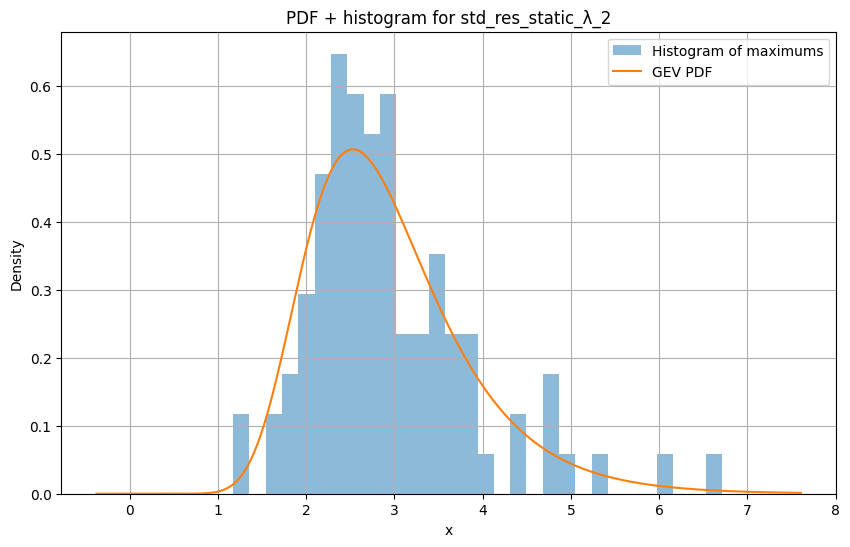

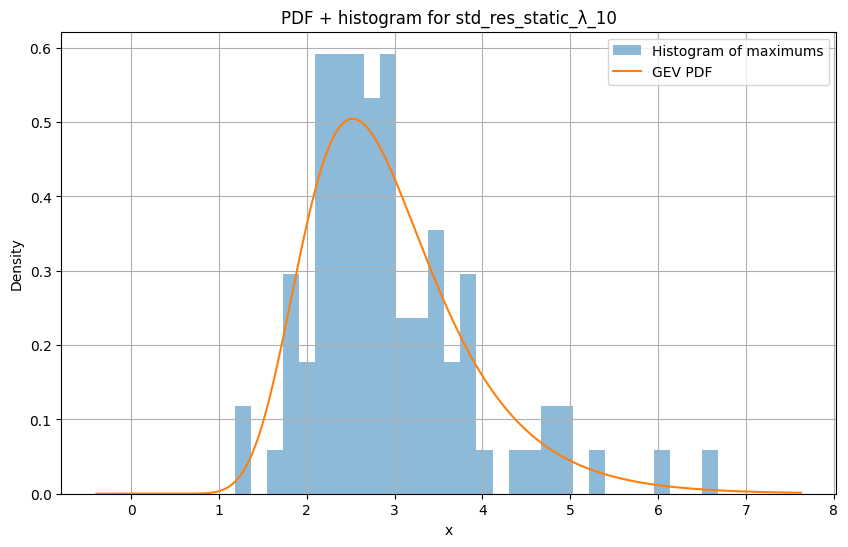

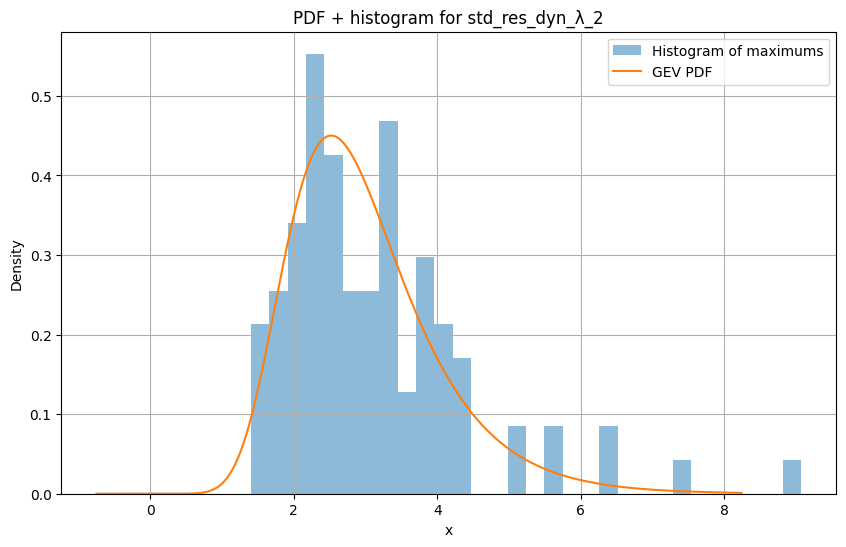

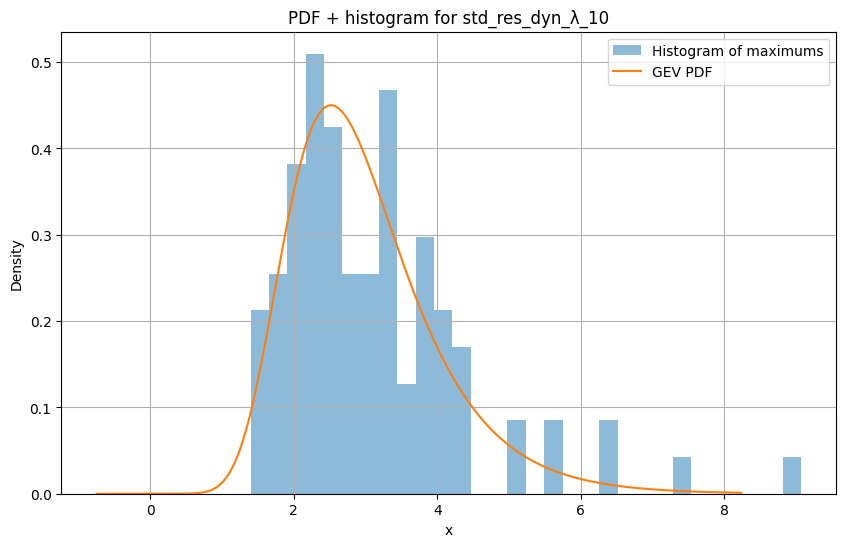

In [299]:

for i in est_param_GEV_df.columns:
    m=max_std_resid_Q[i]
    loc=est_param_GEV_df[i].iloc[0]
    scale=est_param_GEV_df[i].iloc[1]
    shape=est_param_GEV_df[i].iloc[2]

   # Generate x values within a suitable range
    x = np.linspace(loc -4*scale, loc + 7*scale, 1000)

    # Calculate the PDF values
    y = gev_pdf(x, shape, loc, scale)

    # Plot the PDF + hist
    plt.figure(figsize=(10, 6))
    plt.hist(m, bins=30, density=True, alpha=0.5, label='Histogram of maximums')

    plt.plot(x, y, label='GEV PDF')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.title(f'PDF + histogram for {i}')
    plt.legend()
    plt.grid(True)
    plt.show()

Q4.4

In [300]:
quant_dist_gev=[]
quant_dist_std_resid=[]
est_param_GEV_df=est_param_GEV_df.T

for i in range(4):
    N = len(std_resi_df)/len(max_std_resid_Q) # Note : to keep consistency with our quarterly splitting earlier
    loc = est_param_GEV_df['loc']
    scale = est_param_GEV_df['scale']
    shape = est_param_GEV_df['shape']

    # Compute the 99% quantile for the distribution of the maximum mτ
    if shape.iloc[i] < 0.05 and shape.iloc[i] > -0.05: # Gumbel case
        quant_dist_gev.append(loc.iloc[i]-scale.iloc[i]*np.log(-np.log(theta)))
    else:
        quant_dist_gev.append(loc.iloc[i]+(scale.iloc[i]/shape.iloc[i])*((-np.log(theta))**-shape.iloc[i]-1))


    # Compute the 99% quantile of the dist of std resi
    if shape.iloc[i] < 0.05 and shape.iloc[i] > -0.05:
        quant_dist_std_resid.append(loc.iloc[i]-scale.iloc[i]*np.log(-N*np.log(theta)))
    else:    
        quant_dist_std_resid.append(loc.iloc[i] + (scale.iloc[i]/shape.iloc[i])*((-N*np.log(theta))**-shape.iloc[i]-1))



quant_dist = {
    'quant_dist_gev': quant_dist_gev,
    'quant_dist_std_resid': quant_dist_std_resid
}

quant_dist_df = pd.DataFrame(quant_dist,index=['static_λ_2','static_λ_10','dyn_λ_2','dyn_λ_10'])
quant_dist_df

,quant_dist_gev,quant_dist_std_resid
static_λ_2,5.865139,2.834461
static_λ_10,5.877801,2.832244
dyn_λ_2,8.005504,2.877636
dyn_λ_10,8.025159,2.876410


Q4.5

Temporal evolution of the 99% quantile of the loss distribution = GEV VaR

In [301]:
cond_q_L_dist_stat_λ_2=[]
cond_q_L_dist_stat_λ_10=[]
cond_q_L_dist_dyn_λ_2=[]
cond_q_L_dist_dyn_λ_10=[]
# conditional quantiles of the loss distribution
for i in range(len(L_exp_mean['exp Loss static port return λ=2'])):
    # Set variables
    mean = L_exp_mean.iloc[i] 
    std_dev = L_exp_var.iloc[i]**0.5
    quant_dist_std_resid = quant_dist_df['quant_dist_std_resid']


    cond_q_L_dist_stat_λ_2.append(mean.iloc[0] + quant_dist_std_resid.iloc[0]*std_dev.iloc[0])
    cond_q_L_dist_stat_λ_10.append(mean.iloc[1] + quant_dist_std_resid.iloc[1]*std_dev.iloc[1])
    cond_q_L_dist_dyn_λ_2.append(mean.iloc[2] + quant_dist_std_resid.iloc[2]*std_dev.iloc[2])
    cond_q_L_dist_dyn_λ_10.append(mean.iloc[3] + quant_dist_std_resid.iloc[3]*std_dev.iloc[3])
# Transform into a Dataframe
cond_q_L_dist = {
    'cond_q_L_dist_stat_λ_2': cond_q_L_dist_stat_λ_2,
    'cond_q_L_dist_stat_λ_10': cond_q_L_dist_stat_λ_10,
    'cond_q_L_dist_dyn_λ_2': cond_q_L_dist_dyn_λ_2,
    'cond_q_L_dist_dyn_λ_10': cond_q_L_dist_dyn_λ_10
}
cond_q_L_dist_df = pd.DataFrame(cond_q, index=L_exp_mean.index)

In [302]:
cond_q_L_dist_df

,cond_q_stat_λ_2,cond_q_stat_λ_10,cond_q_dyn_λ_2,cond_q_dyn_λ_10
Date,,,,
2001-01-10,0.026173,0.005236,0.082094,0.016446
2001-01-11,0.027019,0.005432,0.095997,0.019311
2001-01-12,0.027885,0.005631,0.129971,0.026155
2001-01-15,0.024273,0.004884,0.090600,0.018181
2001-01-16,0.023813,0.004784,0.074598,0.014934
...,...,...,...,...
2023-12-19,0.017594,0.003585,0.043559,0.008655
2023-12-20,0.017652,0.003606,0.045251,0.008965
2023-12-21,0.018535,0.003707,0.048351,0.009647


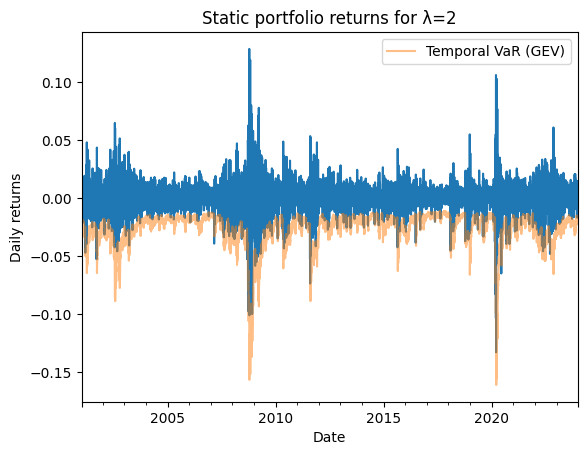

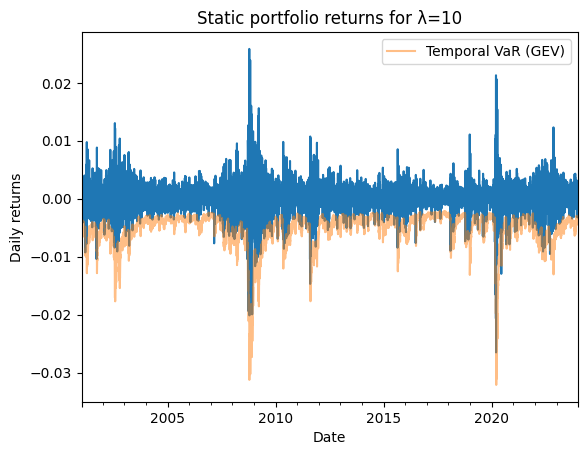

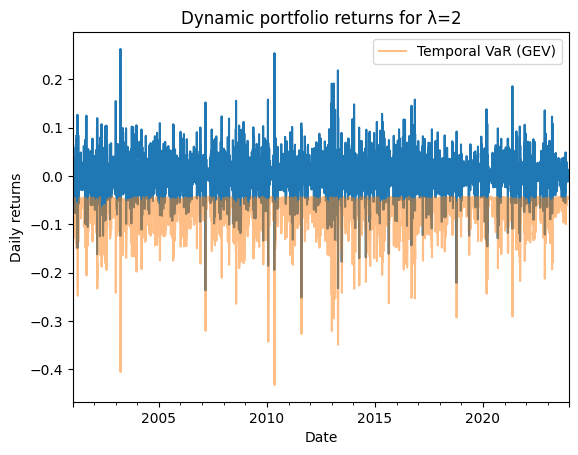

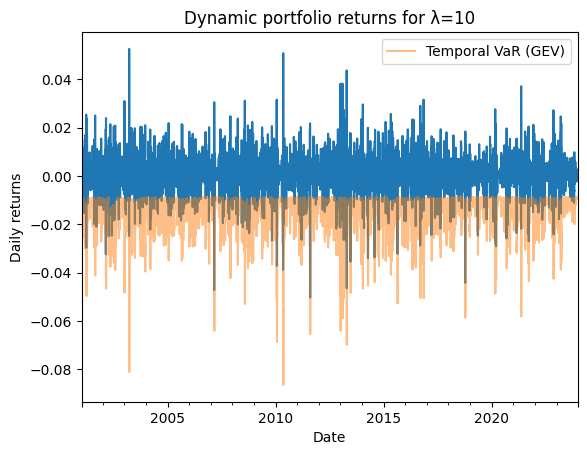

In [303]:
# Plot Portfolio returns + temporal conditional VaR GEV

# Static λ=2
plt.figure()
Daily_static_port_ret_df['Daily static portfolio return for λ=2'].plot(kind='line', title='Static portfolio returns for λ=2',label='_nolegend_')
(-cond_q_L_dist_df['cond_q_stat_λ_2']).plot(label='Temporal VaR (GEV)',alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Daily returns')
plt.legend()
plt.show()

# Static λ=10
plt.figure()
Daily_static_port_ret_df['Daily static portfolio return for λ=10'].plot(kind='line', title='Static portfolio returns for λ=10',label='_nolegend_')
(-cond_q_L_dist_df['cond_q_stat_λ_10']).plot(label='Temporal VaR (GEV)',alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Daily returns')
plt.legend()
plt.show()

# Dynamic λ=2
plt.figure()
Daily_dyn_port_ret_df['Daily dynamic portfolio return for λ=2'].plot(kind='line', title='Dynamic portfolio returns for λ=2',label='_nolegend_')
(-cond_q_L_dist_df['cond_q_dyn_λ_2']).plot(label='Temporal VaR (GEV)',alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Daily returns')
plt.legend()
plt.show()

# Dynamic λ=10
plt.figure()
Daily_dyn_port_ret_df['Daily dynamic portfolio return for λ=10'].plot(kind='line', title='Dynamic portfolio returns for λ=10',label='_nolegend_')
(-cond_q_L_dist_df['cond_q_dyn_λ_10']).plot(label='Temporal VaR (GEV)',alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Daily returns')
plt.legend()
plt.show()